# Predicting Lending Decisions: Analysis of the LendingClub Dataset III part

In this part of the analysis the machine learning models will be trained in order to predict the grade for the loan, that is, a categorical variable with multiple values. 

### Importing libraries for the II part

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib, seaborn and yellowbrick will be used for data visualization. Scipy, Statsmodels, Researchpy, Math, Random will be used for conducting statistical tests, calculating confidence intervals. Sklearn will be used for spliting data into training and testing samples, building and testing machine learning models.

In [3]:
import numpy as np 
import pandas as pd
import sqlite3
import duckdb
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy import stats
from scipy.stats import chi2_contingency, norm 
import researchpy as rp

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import optuna

import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
recall_score, confusion_matrix, make_scorer, classification_report

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
import xgboost as xgb

from imblearn.pipeline import make_pipeline, Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from yellowbrick.classifier import confusion_matrix, ClassificationReport

import joblib
import shap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from lending_utils import *


## III. PREDICTING THE GRADE FOR THE LOAN

### Importing the data

For this part only the dataset 'accepted.csv' will be needed for the analysis. This dataset is imported and saved into pandas dataframe.

In [4]:
accepted = pd.read_csv("data/accepted.csv")


### Preparing the data for the further analysis

The data will be prepared with the same steps as in the I part.

It can be seen that the dataframe "accepted", beginning from the row index 2260699, includes rows with missing data. These rows are removed from the dataframe.

Also, geographical and personal data would certainly not be used for the analysis, thus, these columns were removed from the dataframes.

In [5]:
accepted_mod = accepted.loc[:2260698, :]

In [6]:
accepted_mod = accepted_mod.drop(columns=["id", 'member_id', 'url', 'zip_code', 'addr_state'])


#### Initial feature selection

The initial list of features is selected based on the descriptions of these features in the data dictionary https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv?select=LCDataDictionary.xlsx. The selection of the features is not well-justified, as the time to understand the financial data for this project is limited. Also, features such as emp_length, risk_score are prepared as in the same way as in the part I.

In [7]:
grade_prediction = accepted_mod[["grade","loan_amnt", "loan_status",
                                 "emp_length",
                                 "delinq_2yrs", 
                             'fico_range_low','fico_range_high',
                                 'annual_inc',
                             'inq_last_6mths','pub_rec',
                             'revol_util',
                                 'home_ownership',
                                 'purpose',
                            'total_acc','initial_list_status',
                             'dti','acc_now_delinq',
                            'tot_cur_bal','il_util','all_util',
                             'inq_fi','inq_last_12m','chargeoff_within_12_mths',
                            'delinq_amnt','mths_since_last_major_derog',
                            'mths_since_last_record','mths_since_recent_bc_dlq',
                            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
                            'pct_tl_nvr_dlq','pub_rec_bankruptcies','tot_hi_cred_lim',
                             'total_bc_limit','total_il_high_credit_limit',
                            'verification_status']]

In [8]:
grade_prediction_mod = duckdb.sql("""SELECT
                     grade,
                     loan_amnt AS loan_amount,
                      CASE
                      WHEN emp_length = '< 1 year' THEN 0
                      WHEN emp_length = '1 year' THEN 1
                      WHEN emp_length = '2 years' THEN 2
                      WHEN emp_length = '3 years' THEN 3
                      WHEN emp_length = '4 years' THEN 4
                      WHEN emp_length = '5 years' THEN 5
                      WHEN emp_length = '6 years' THEN 6
                      WHEN emp_length = '7 years' THEN 7
                      WHEN emp_length = '8 years' THEN 8
                      WHEN emp_length = '9 years' THEN 9
                      ELSE 10 END AS emp_length,
                     annual_inc, loan_status, delinq_2yrs,
                         (fico_range_low + fico_range_high)/2 AS risk_score,
                             inq_last_6mths,pub_rec,
                             revol_util,
                            total_acc,initial_list_status,
                             dti,acc_now_delinq,
                            tot_cur_bal,il_util,all_util,
                                 home_ownership,
                                 purpose,
                             inq_fi,inq_last_12m,chargeoff_within_12_mths,
                            delinq_amnt,mths_since_last_major_derog,
                            mths_since_last_record,mths_since_recent_bc_dlq,
                            mths_since_recent_inq, mths_since_recent_revol_delinq,
                            pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,
                             total_bc_limit,total_il_high_credit_limit,
                            verification_status
                      FROM grade_prediction
                            """).df()
pd.set_option('display.max_columns', 500)
grade_prediction_mod.head()

,grade,loan_amount,emp_length,annual_inc,loan_status,delinq_2yrs,risk_score,inq_last_6mths,pub_rec,revol_util,total_acc,initial_list_status,dti,acc_now_delinq,tot_cur_bal,il_util,all_util,home_ownership,purpose,inq_fi,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,verification_status
0,C,3600.0,10,55000.0,Fully Paid,0.0,677.0,1.0,0.0,29.7,13.0,w,5.91,0.0,144904.0,36.0,34.0,MORTGAGE,debt_consolidation,3.0,4.0,0.0,0.0,30.0,NaN,69.0,4.0,69.0,76.9,0.0,178050.0,2400.0,13734.0,Not Verified
1,C,24700.0,10,65000.0,Fully Paid,1.0,717.0,4.0,0.0,19.2,38.0,w,16.06,0.0,204396.0,73.0,29.0,MORTGAGE,small_business,0.0,6.0,0.0,0.0,NaN,NaN,NaN,0.0,6.0,97.4,0.0,314017.0,79300.0,24667.0,Not Verified
2,B,20000.0,10,63000.0,Fully Paid,0.0,697.0,0.0,0.0,56.2,18.0,w,10.78,0.0,189699.0,73.0,65.0,MORTGAGE,home_improvement,2.0,1.0,0.0,0.0,NaN,NaN,NaN,10.0,NaN,100.0,0.0,218418.0,6200.0,14877.0,Not Verified
3,C,35000.0,10,110000.0,Current,0.0,787.0,0.0,0.0,11.6,17.0,w,17.06,0.0,301500.0,70.0,45.0,MORTGAGE,debt_consolidation,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,381215.0,62500.0,18000.0,Source Verified
4,F,10400.0,3,104433.0,Fully Paid,1.0,697.0,3.0,0.0,64.5,35.0,w,25.37,0.0,331730.0,84.0,78.0,MORTGAGE,major_purchase,2.0,3.0,0.0,0.0,NaN,NaN,12.0,1.0,12.0,96.6,0.0,439570.0,20300.0,88097.0,Source Verified


#### Categorical variables

First, categorical variables from the list of selected features are examined.

In [9]:
grade_prediction_describe = grade_prediction_mod.describe()

In [10]:
grade_prediction_cat = grade_prediction_mod.copy()
for i in range(len(grade_prediction_describe.columns)):
    grade_prediction_cat =  grade_prediction_cat.drop(columns = [grade_prediction_describe.columns[i]])                                   
   

In [11]:
grade_prediction_cat.head()

,grade,loan_status,initial_list_status,home_ownership,purpose,verification_status
0,C,Fully Paid,w,MORTGAGE,debt_consolidation,Not Verified
1,C,Fully Paid,w,MORTGAGE,small_business,Not Verified
2,B,Fully Paid,w,MORTGAGE,home_improvement,Not Verified
3,C,Current,w,MORTGAGE,debt_consolidation,Source Verified
4,F,Fully Paid,w,MORTGAGE,major_purchase,Source Verified


The distributions of variables are plites with count plots of the seaborn library.

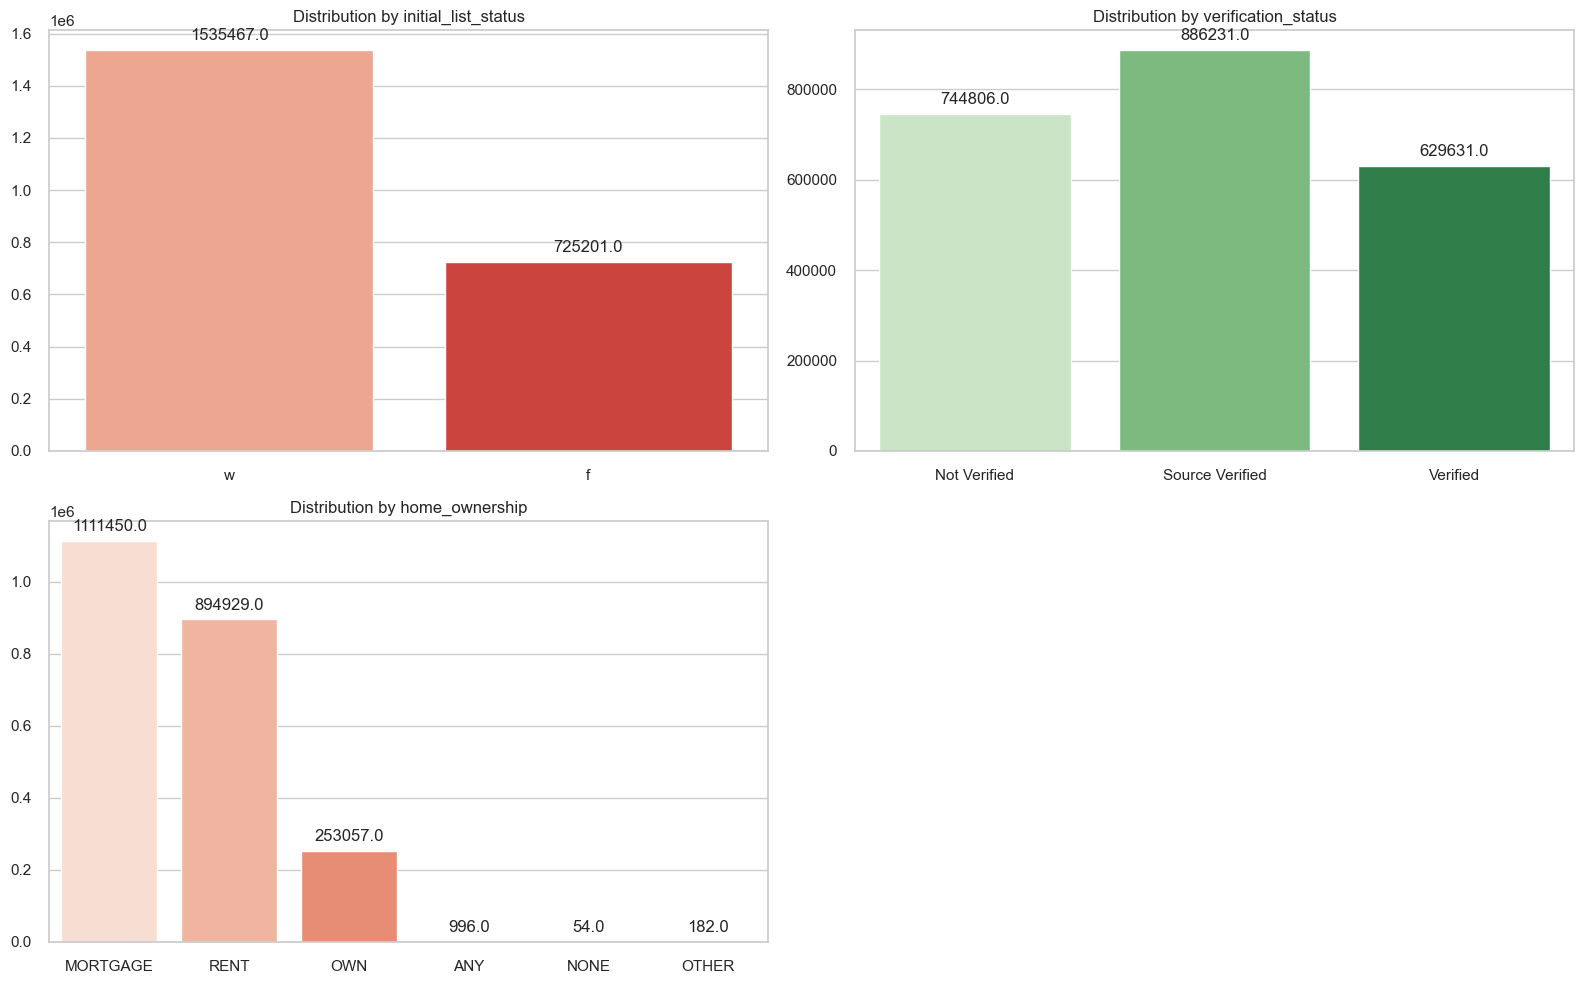

In [13]:
sns.set(style='whitegrid')

# Create a figure with subplots
plt.figure(figsize=[16, 10])

plt.subplot(221)
ax1 = sns.countplot(x='initial_list_status', data=grade_prediction_mod, palette='Reds')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution by initial_list_status')

plt.subplot(222)
ax2 = sns.countplot(x='verification_status', data=grade_prediction_mod, palette='Greens')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

plt.xlabel('')
plt.ylabel('')
plt.title('Distribution by verification_status')

plt.subplot(223)
ax3 = sns.countplot(x='home_ownership', data=grade_prediction_mod, palette='Reds')
for p in ax3.patches:
    ax3.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution by home_ownership')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show();


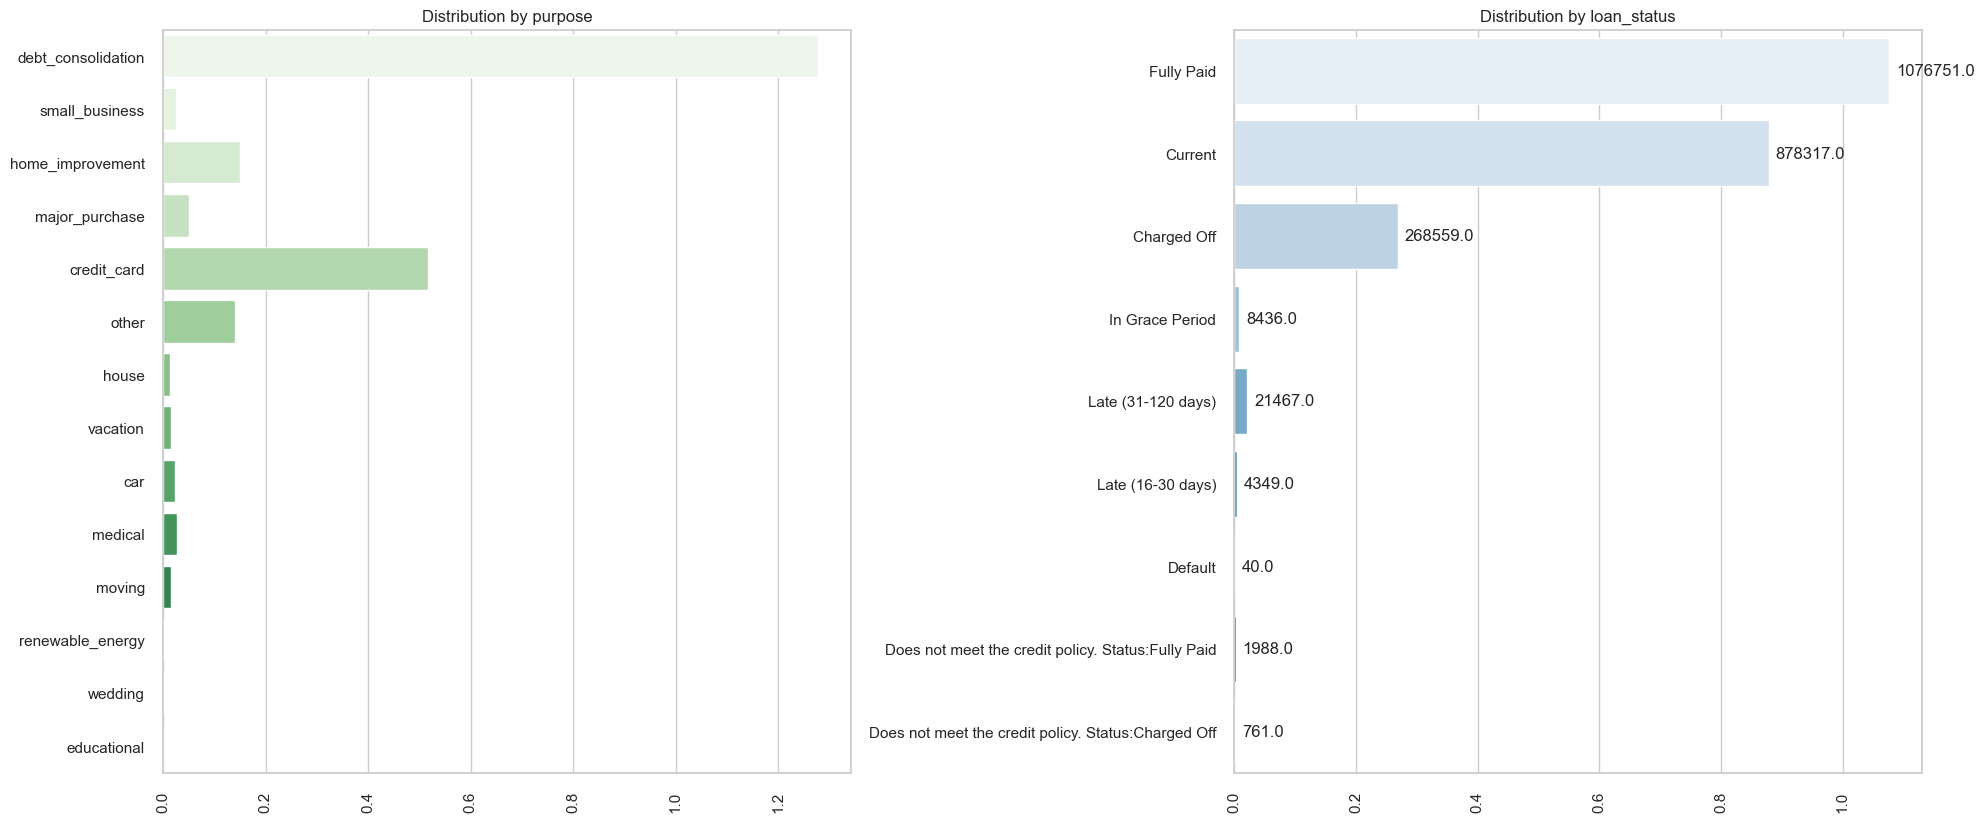

In [14]:
sns.set(style='whitegrid')

# Create a figure with subplots
plt.figure(figsize=[20, 16])

plt.subplot(221)
ax1 = sns.countplot(y='purpose', data=grade_prediction_mod, palette='Greens')
for p in ax2.patches:
    ax1.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                 xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.xlabel('')
plt.ylabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.title('Distribution by purpose')

plt.subplot(222)
ax2 = sns.countplot(y='loan_status', data=grade_prediction_mod, palette='Blues')
for p in ax2.patches:
    ax2.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                 xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.xlabel('')
plt.ylabel('')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.title('Distribution by loan_status')

plt.tight_layout()

# Show the plot
plt.show();

It can be observed from the plots that some values of such variables as 'loan_status', 'homo_ownership' and 'purpose' are shared just by small numbers of loan receivers, thus, it potentially could create problems in the machine learning state as some values would be present in the training dataset but absent in validation or test datasets.

#### Numerical variables:

Numerical variables from the list of features were selected and examined with the function 'describe' and histogram plots.

In [10]:
grade_prediction_describe = grade_prediction_mod.describe().round(2)
grade_prediction_describe.head()

,loan_amount,emp_length,annual_inc,delinq_2yrs,risk_score,inq_last_6mths,pub_rec,revol_util,total_acc,dti,acc_now_delinq,tot_cur_bal,il_util,all_util,inq_fi,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit
count,2260668.00,2260699.00,2260664.00,2260639.00,2260668.00,2260638.00,2260639.00,2258866.00,2260639.00,2258957.00,2260639.00,2190392.00,1191818.00,1394320.00,1394539.00,1394538.00,2260523.00,2260639.00,580775.00,359156.00,519701.00,1965233.00,740359.00,2190237.00,2259303.00,2190392.00,2210638.00,2190392.00
mean,15046.93,6.20,77992.43,0.31,700.59,0.58,0.20,50.34,24.16,18.82,0.00,142492.20,69.14,57.03,1.01,2.04,0.01,12.37,44.16,72.31,39.30,7.02,35.78,94.11,0.13,178242.75,23193.77,43732.01
std,9190.25,3.73,112696.20,0.87,33.01,0.89,0.57,24.71,11.99,14.18,0.07,160692.64,23.75,20.90,1.49,2.38,0.10,726.46,21.53,26.46,22.62,5.97,22.31,9.04,0.36,181574.81,23006.56,45072.98
min,500.00,0.00,0.00,0.00,612.00,0.00,0.00,0.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8000.00,3.00,46000.00,0.00,677.00,0.00,0.00,31.50,15.00,11.89,0.00,29092.00,55.00,43.00,0.00,0.00,0.00,0.00,27.00,55.00,21.00,2.00,17.00,91.30,0.00,50731.00,8300.00,15000.00


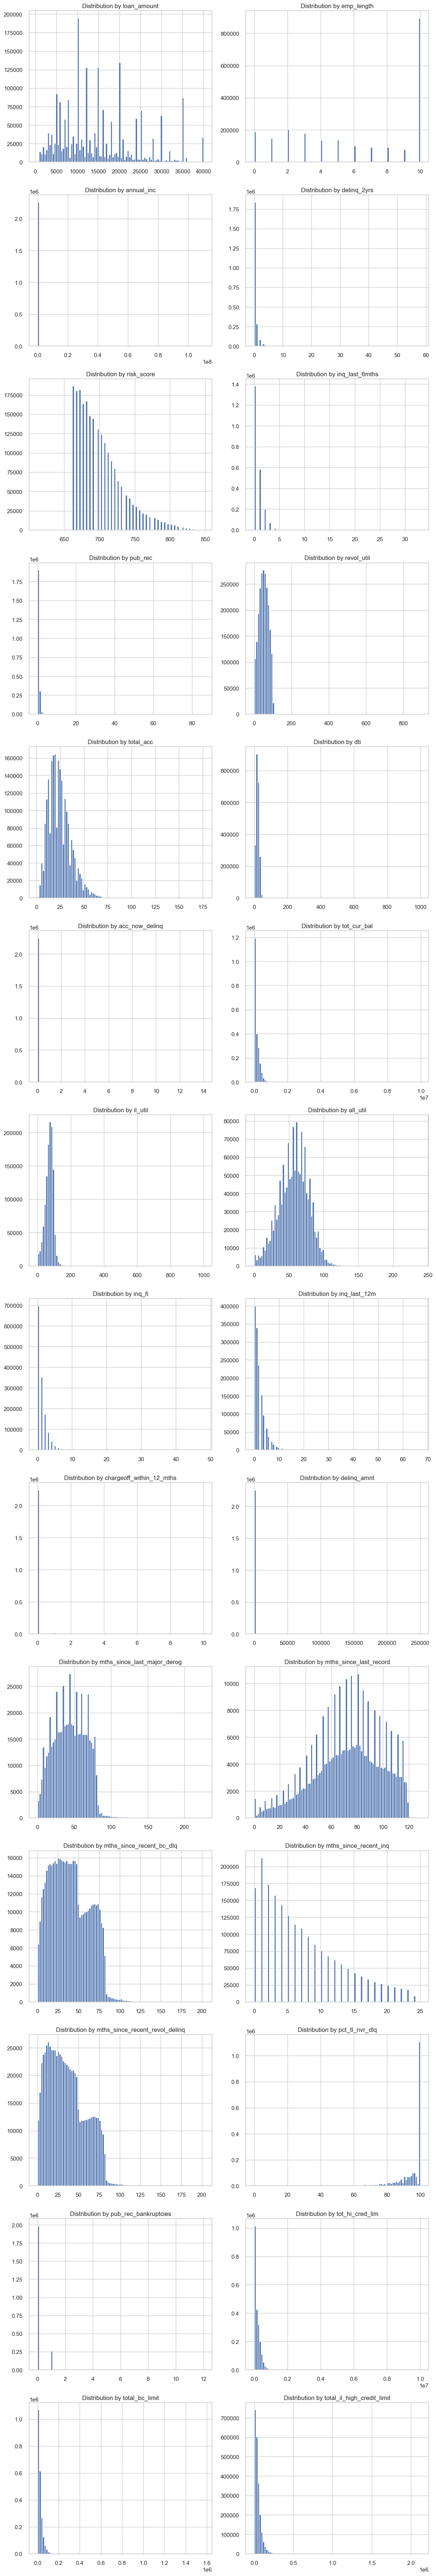

In [15]:
fig, axs = plt.subplots(14, 2, figsize=(12, 70))
i = 0
j = 0
while i<=13:
    axs[i, 0].hist(grade_prediction_mod[f'{grade_prediction_describe.columns[j]}'],bins=100,color='b')
    axs[i, 0].set_title(f'Distribution by {grade_prediction_describe.columns[j]}')
    axs[i, 1].hist(grade_prediction_mod[grade_prediction_describe.columns[j+1]],bins=100,color='b')
    axs[i, 1].set_title(f'Distribution by {grade_prediction_describe.columns[j+1]}')
    i+=1
    j+=2

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show();

It can be observed that only few variables are normally distributed. Many of variables have higher numbers of outliers.

#### 'grade' as a target variable:

The target variable is a categorical variable with 7 features. The variable is imbalanced - F and G grades are less represented in the dataset.

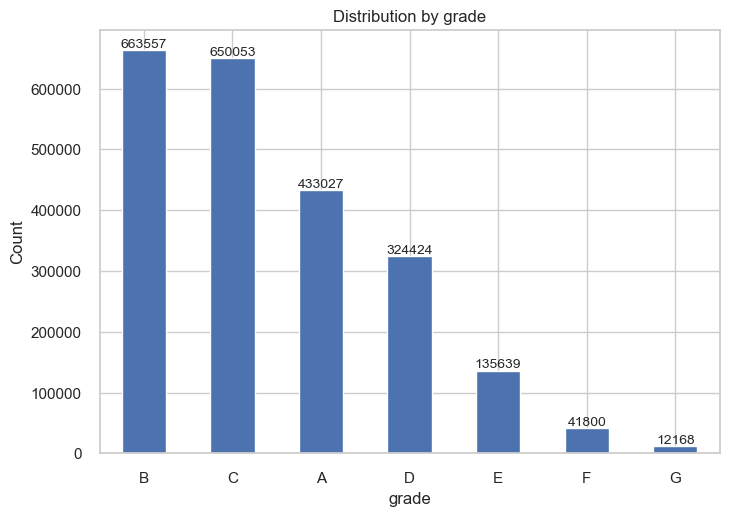

In [15]:

ax = grade_prediction_mod["grade"].value_counts().plot(kind="bar")
plt.title("Distribution by grade", fontsize=12)
plt.xlabel("grade", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize=12)

# Add value labels on top of each bar
for i, count in enumerate(grade_prediction["grade"].value_counts()):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show();

### Examining relationships between categorical feature variables and a target variable

In order to examine which of the categorical feature variables has a effect on the target variable, chi square tests were performed.

In [18]:
frames = {}
for i in range(0, (len(grade_prediction_cat.columns)-1)):
    table = pd.crosstab(grade_prediction_cat.loc[:,"grade"],grade_prediction_cat.iloc[:,i], dropna=False)
    table = (table/table.sum()*100).round(2)
    frames[i]=pd.DataFrame(table).transpose()

for i in range(1,len(frames)):
    print(frames[i])
    print('')

grade                                                   A      B      C  \
loan_status                                                               
Charged Off                                          5.29  19.57  31.89   
Current                                             22.26  29.93  29.11   
Default                                             12.50  17.50  20.00   
Does not meet the credit policy. Status:Charged...   1.05  11.17  19.45   
Does not meet the credit policy. Status:Fully Paid   4.53  13.53  24.20   
Fully Paid                                          20.51  31.59  27.49   
In Grace Period                                      7.49  20.99  35.48   
Late (16-30 days)                                    7.84  22.83  33.94   
Late (31-120 days)                                   6.16  22.30  35.19   

grade                                                   D      E      F     G  
loan_status                                                                    
Charged Off   

In [28]:
def chi_square_test(data, confidence, variable):
    stat, p, dof, expected = stats.chi2_contingency(data)
    alpha = 1 - confidence
    print(f'Pearson chi square test:{stat.round(3)}')
    print(f'P_value: {p.round(3)}')
    return p

In [35]:
conf_levels = [0.9, 0.95, 0.99]
for conf_level in conf_levels:
    significant = []
    unsignificant = [] 
    accepted_list = []
    rejected_list = []
    print(f'Confidence level - {conf_level}:')
    print('')
    for i in range(1,len(frames)):
        p = chi_square_test(frames[i], conf_level, grade_prediction_cat.columns[i])
        if p <= 1 - conf_level:
            print('')
            print(f'With regard to the variable {grade_prediction_cat.columns[i]},\
there are statistically signifficant differences among \ngroups of persons \
with different grades (the H0 hypothesis is rejected).')
            print('')
            significant.append(grade_prediction_cat.columns[i])
        else:
            print('')
            print(f'With regard to the variable {grade_prediction_cat.columns[i]},\
there are no statistically signifficant differences among \ngroups of persons \
with different grades (the H0 hypothesis is not rejected).')
            print('')
            unsignificant.append(grade_prediction_cat.columns[i])
    print('')
    print('')
    print(f'Significant statistical differences in groups of persons \
with different grades are for these variables:\n\
    {significant})')
    print(f'Unsignificant statistical differences in groups of of persons \
with different grades are for these variables:\n\
    {unsignificant})')
    print('')
    print('')

Confidence level - 0.9:

Pearson chi square test:165.859
P_value: 0.0

With regard to the variable loan_status,there are statistically signifficant differences among 
groups of persons with different grades (the H0 hypothesis is rejected).

Pearson chi square test:4.195
P_value: 0.65

With regard to the variable initial_list_status,there are no statistically signifficant differences among 
groups of persons with different grades (the H0 hypothesis is not rejected).

Pearson chi square test:32.116
P_value: 0.362

With regard to the variable home_ownership,there are no statistically signifficant differences among 
groups of persons with different grades (the H0 hypothesis is not rejected).

Pearson chi square test:70.984
P_value: 0.7

With regard to the variable purpose,there are no statistically signifficant differences among 
groups of persons with different grades (the H0 hypothesis is not rejected).



Significant statistical differences in groups of persons with different grades are

It can be observed that for all significance levels, statistically significant differences are observed for the variable 'loan_status' while for other variables such as 'purpose', 'home_ownership', and 'initial_list_status' there are no statistically significant differences with regard to the target variable 'grade'. 

It can be observed from the contingency table that persons who are current or fully paid more often receive higer grades (grade 'A' - 22 percent 'current', 20 percent 'fully paid"; grade 'B' - 30 percent 'current', 32 percent 'fully paid').

### Examining relationships between numeric variables

Next, it was examined if there are correlations between numerical variables. 

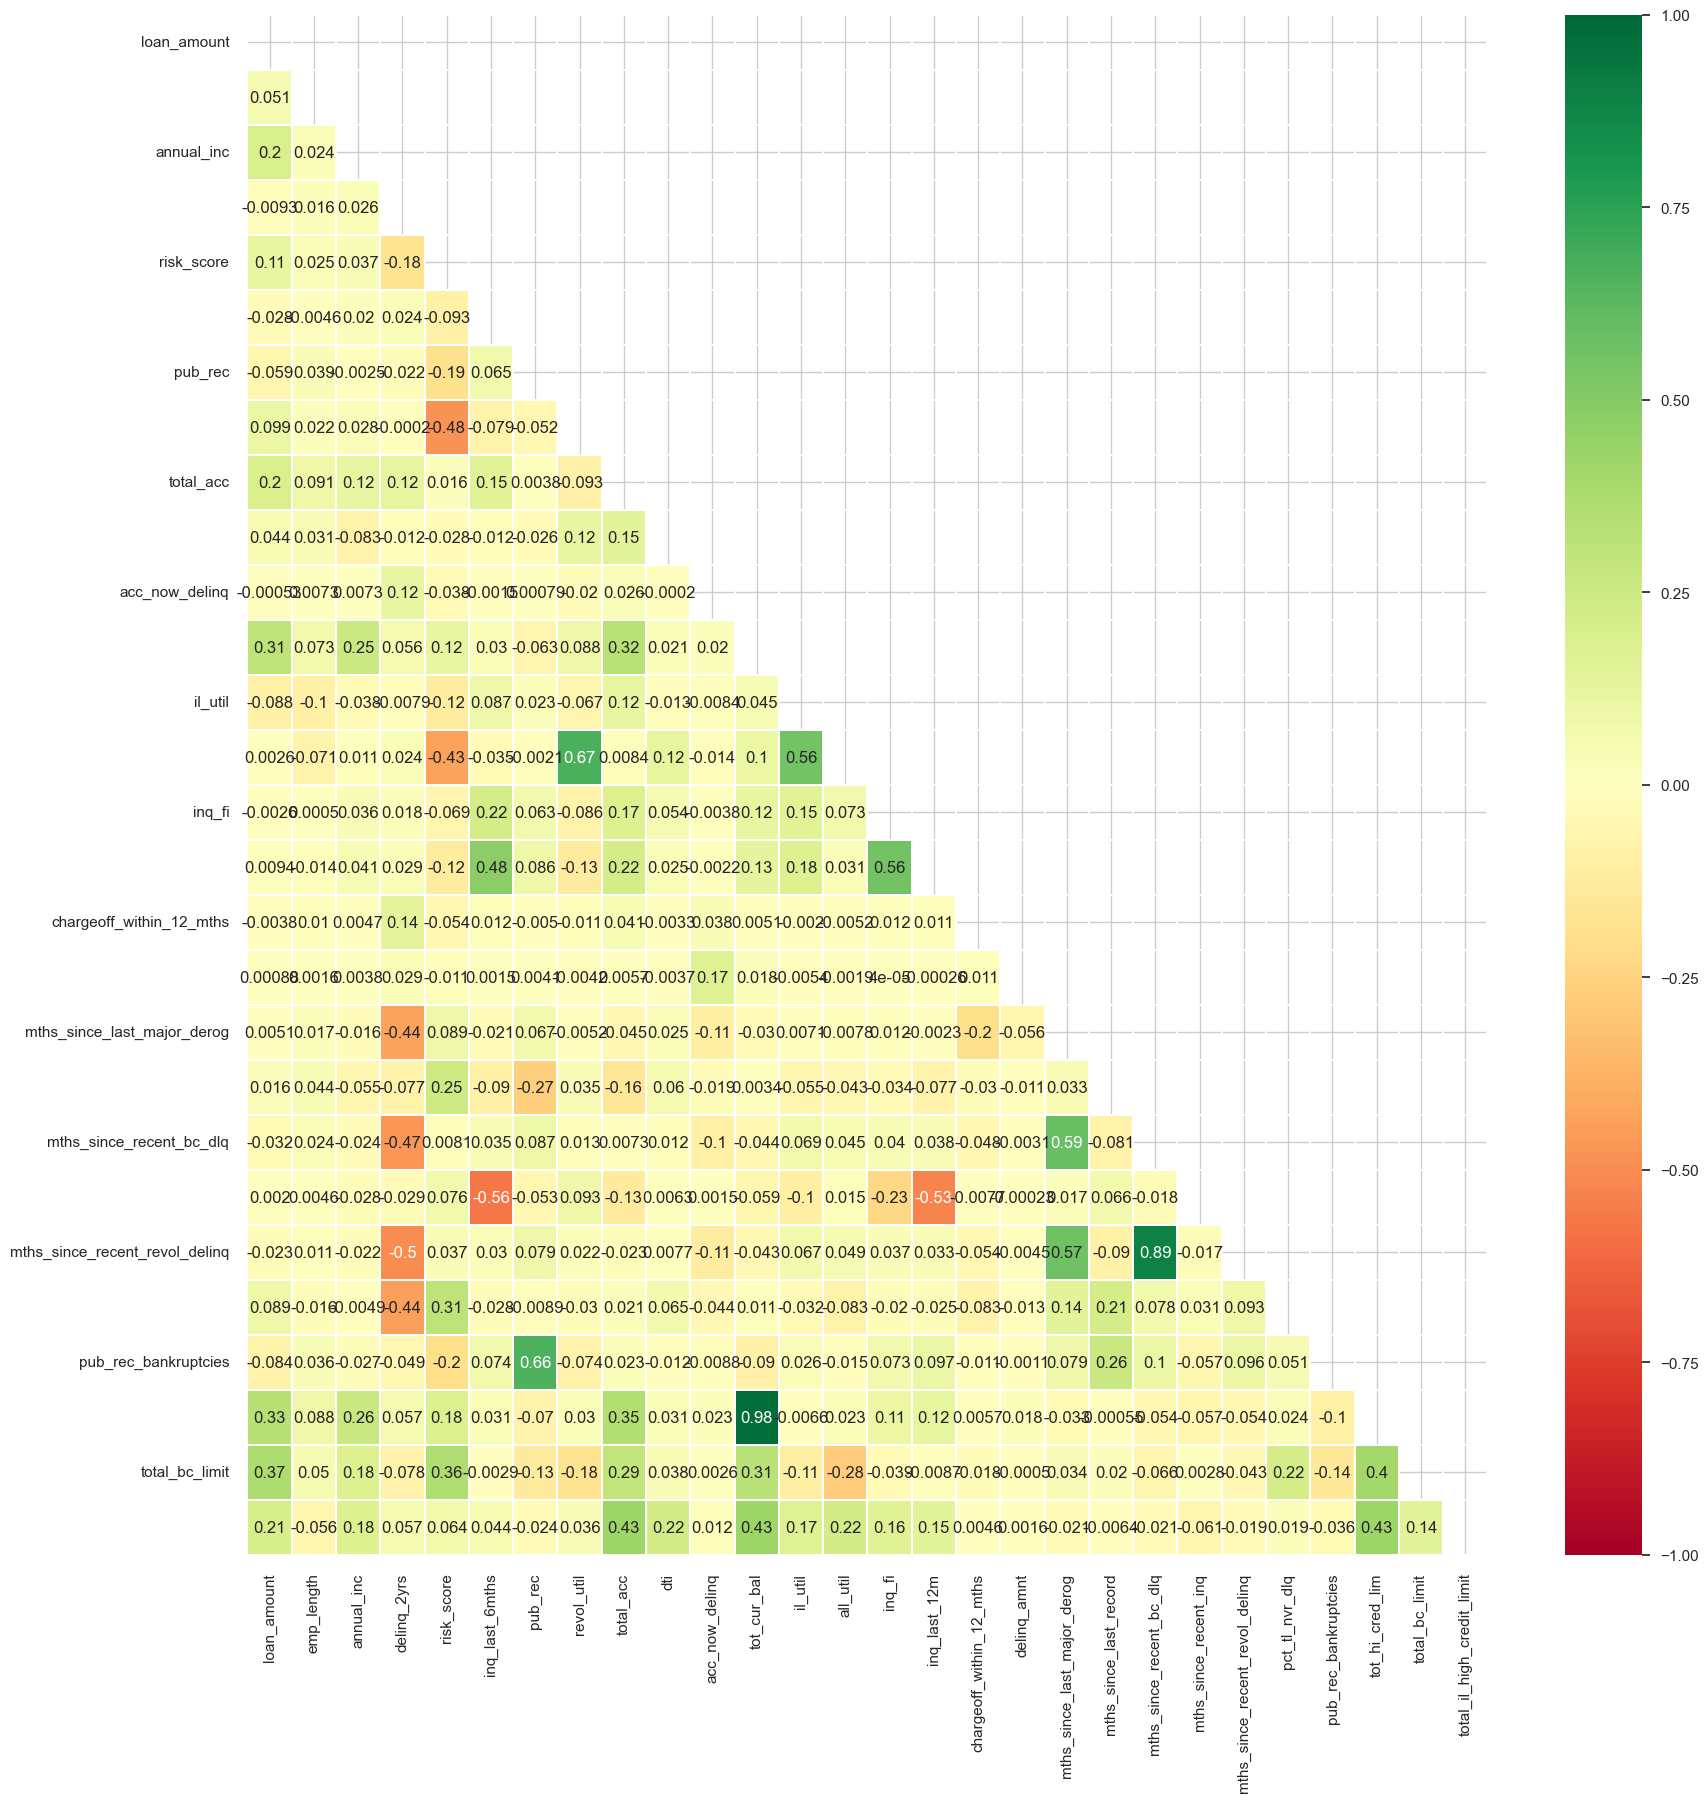

In [17]:
correlation_matrix = grade_prediction_mod.iloc[:, :-1].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', 
            vmin=-1, vmax=1, linewidths=0.2, mask=mask)

fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.show();

It can be seen that some of these variables are highly correlated between each other, thus, one variables in those pairs of those highly correlated variables can be removed. 

### Checking for outliers

Outliers were examined in the numerical variables. 

In [18]:
for i in range(len(grade_prediction_mod.columns)):
    if type(grade_prediction_mod.iloc[0,i]) is not str:
        find_outliers(grade_prediction_mod,i,1.5)
    else:
        pass

The variable: loan_amount
The number of lower outliers is:0,    The number of upper outliers is :35215

The variable: emp_length
The number of lower outliers is:0,    The number of upper outliers is :0

The variable: annual_inc
The number of lower outliers is:0,    The number of upper outliers is :110041

The variable: delinq_2yrs
The number of lower outliers is:0,    The number of upper outliers is :421531

The variable: risk_score
The number of lower outliers is:2,    The number of upper outliers is :74844

The variable: inq_last_6mths
The number of lower outliers is:0,    The number of upper outliers is :94314

The variable: pub_rec
The number of lower outliers is:0,    The number of upper outliers is :357881

The variable: revol_util
The number of lower outliers is:0,    The number of upper outliers is :114

The variable: total_acc
The number of lower outliers is:0,    The number of upper outliers is :39411

The variable: dti
The number of lower outliers is:0,    The number of uppe

It can be seen that most of the variables have high numbers of outliers. 

### Checking for missing values

Also, it was found that some of the variables in the list of features have quite high numbers of missing values. 

In [50]:
grade_prediction_mod.isnull().sum() 

grade                                  31
loan_amount                            31
emp_length                              0
annual_inc                             35
loan_status                            31
delinq_2yrs                            60
risk_score                             31
inq_last_6mths                         61
pub_rec                                60
revol_util                           1833
total_acc                              60
initial_list_status                    31
dti                                  1742
acc_now_delinq                         60
tot_cur_bal                         70307
il_util                           1068881
all_util                           866379
home_ownership                         31
purpose                                31
inq_fi                             866160
inq_last_12m                       866161
chargeoff_within_12_mths              176
delinq_amnt                            60
mths_since_last_major_derog       

### Cleaning up the data

In order to prepare the dataset which could be used for machine learning, data have to be cleaned. Bellow, several approaches to cleaning data were applied for different variables. 

##### Dropping rows with missing values

Rows with missing values for some of variables were removed. It was supposed that it would not negativelly affect the analysis as there are still a lot of data left.

In [53]:
grade_prediction_mod1 = grade_prediction_mod.dropna(subset=['grade','dti','revol_util','pub_rec_bankruptcies',
                                                                'chargeoff_within_12_mths','inq_last_6mths'])
grade_prediction_mod1.isnull().sum() 

grade                                   0
loan_amount                             0
emp_length                              0
annual_inc                              0
loan_status                             0
delinq_2yrs                             0
risk_score                              0
inq_last_6mths                          0
pub_rec                                 0
revol_util                              0
total_acc                               0
initial_list_status                     0
dti                                     0
acc_now_delinq                          0
tot_cur_bal                         68817
il_util                           1066175
all_util                           864299
home_ownership                          0
purpose                                 0
inq_fi                             864299
inq_last_12m                       864299
chargeoff_within_12_mths                0
delinq_amnt                             0
mths_since_last_major_derog       

##### Dropping rows with certain values

Rows with small numbers of values for some of the variables were dropped from the dataset in order to avoid the data not being present in either training or test datasets. 

In [54]:
grade_prediction_mod2 = grade_prediction_mod1[(grade_prediction_mod1["loan_status"] != "Default") & \
    (grade_prediction_mod1["loan_status"] != "Does not meet the credit policy. Status:Charged Off") & \
     (grade_prediction_mod1["loan_status"] != "Does not meet the credit policy. Status:Fully Paid") &\
     (grade_prediction_mod1["loan_status"] != "Late (31-120 days)") &\
     (grade_prediction_mod1["loan_status"] != "Late (16-30 days)")]


In [55]:
grade_prediction_mod2 = grade_prediction_mod2[(grade_prediction_mod2["purpose"] != "wedding") & \
    (grade_prediction_mod2["purpose"] != "educational") & \
     (grade_prediction_mod2["purpose"] != "renewable_energy") &\
    (grade_prediction_mod2["purpose"] != "house")]

In [56]:
grade_prediction_mod2 = grade_prediction_mod2[(grade_prediction_mod2["home_ownership"] != "ANY") & \
    (grade_prediction_mod2["home_ownership"] != "NONE") & \
     (grade_prediction_mod2["home_ownership"] != "OTHER")]

In [57]:
grade_prediction_mod2.value_counts("loan_status")

loan_status
Fully Paid         1066205
Current             868460
Charged Off         265964
In Grace Period       8351
dtype: int64

##### Dropping rows with values which are out of scales

Rows with values which do not fit into scale for such variable as 'dti' were also removed.

In [58]:
grade_prediction_mod2 = grade_prediction_mod2[(grade_prediction_mod2.dti <= 100)&(grade_prediction_mod2.dti > 0)]

##### Dropping certain variables

After the correlation analysis one of two highly correlated features (such as 'tol_cur_bal' and 'tot_hi_cred_lim' and 'mths_since_recent_bc_dlq' and 'mths_since_recent_revol_delinq') was removed from the data set. Also, some features which are not well undestood or were supposed to characterize companies and not individuals or having highly skewed distributions were also removed from the list of features. 

In [59]:
grade_prediction_mod3 = grade_prediction_mod2.drop(columns = ['tot_hi_cred_lim', 
                                                                'mths_since_recent_bc_dlq', 
                                                                'mths_since_last_major_derog',
                                                                'mths_since_last_record',
                                                               'mths_since_recent_inq',
                                                                'tot_cur_bal',
                                                                'mths_since_recent_revol_delinq',
                                                               'il_util', 'all_util',
                                                                'inq_fi','inq_last_12m',
                                                               'pct_tl_nvr_dlq','total_bc_limit',
                                                                'total_il_high_credit_limit'])

### Machine learning

#### Randomly selecting the data for machine learning

For machine learning purposes the the random sample of 10000 rows was selected.

In [61]:
grade_prediction_sample = grade_prediction_mod3.sample(n=10000)
grade_prediction_sample.head()

,grade,loan_amount,emp_length,annual_inc,loan_status,delinq_2yrs,risk_score,inq_last_6mths,pub_rec,revol_util,total_acc,initial_list_status,dti,acc_now_delinq,home_ownership,purpose,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,verification_status
1081842,A,28000.0,10,160000.0,Fully Paid,0.0,742.0,1.0,0.0,45.0,26.0,f,10.26,0.0,MORTGAGE,debt_consolidation,0.0,0.0,0.0,Verified
1631773,B,10000.0,3,115000.0,Fully Paid,0.0,687.0,0.0,0.0,52.1,43.0,f,12.38,0.0,RENT,debt_consolidation,0.0,0.0,0.0,Not Verified
2019494,C,10000.0,10,40000.0,Fully Paid,0.0,722.0,0.0,1.0,32.6,36.0,f,33.75,0.0,MORTGAGE,debt_consolidation,0.0,0.0,1.0,Not Verified
852393,C,15000.0,2,85000.0,Current,0.0,672.0,0.0,0.0,27.0,19.0,w,14.09,0.0,RENT,debt_consolidation,0.0,0.0,0.0,Not Verified
509536,B,6000.0,10,30000.0,Current,0.0,702.0,0.0,1.0,46.1,14.0,w,34.32,0.0,MORTGAGE,credit_card,0.0,0.0,1.0,Source Verified


It can be seen that the sample has 19 features and one target variable.

In [63]:
grade_prediction_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1081842 to 1755019
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   grade                     10000 non-null  object 
 1   loan_amount               10000 non-null  float64
 2   emp_length                10000 non-null  int32  
 3   annual_inc                10000 non-null  float64
 4   loan_status               10000 non-null  object 
 5   delinq_2yrs               10000 non-null  float64
 6   risk_score                10000 non-null  float64
 7   inq_last_6mths            10000 non-null  float64
 8   pub_rec                   10000 non-null  float64
 9   revol_util                10000 non-null  float64
 10  total_acc                 10000 non-null  float64
 11  initial_list_status       10000 non-null  object 
 12  dti                       10000 non-null  float64
 13  acc_now_delinq            10000 non-null  float64
 14

#### Encoding the target variable and spliting the data into training, validation, and test datasets

First, the data were split into feature variables and target variable as well as into training and testing datasets. The target variable was encoded with the label encoder, the dictionary with coresponding keys (in order to know which keys represent which values) was created.

70 percent of data were included into the training dataset, 30 percent into the testing dataset. The training data set was split into  half (for training and validation).

In [71]:
X = grade_prediction_sample.drop(['grade'],axis=1)
y = grade_prediction_sample['grade']


In [72]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [73]:
name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(name_mapping)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=123, stratify = y_train)

#### Building a machine learning pipeline

Next, pipelines of transforming data were constructed. As for some categorical variables it was needed to encode them into numbers, one hot encoder function was applied. For numerical variables, standart scaler was applied to transform the variables into comparable scales.

In [75]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
     ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore')),
])


In [76]:
grade_prediction_mod3_describe = grade_prediction_mod3.describe()
print(grade_prediction_mod3_describe.columns)
grade_prediction_cat = grade_prediction_mod3.copy()
for i in range(len(grade_prediction_mod3_describe.columns)):
    grade_prediction_cat =  grade_prediction_cat.drop\
    (columns = [grade_prediction_mod3_describe.columns[i]])
print(grade_prediction_cat.columns)

Index(['loan_amount', 'emp_length', 'annual_inc', 'delinq_2yrs', 'risk_score',
       'inq_last_6mths', 'pub_rec', 'revol_util', 'total_acc', 'dti',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies'],
      dtype='object')
Index(['grade', 'loan_status', 'initial_list_status', 'home_ownership',
       'purpose', 'verification_status'],
      dtype='object')


In [77]:
numeric_features = list(grade_prediction_mod3_describe.columns)
categorical_features = list(grade_prediction_cat.columns)[1:]

In [78]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
]) 

In [79]:
classifiers = [
    xgb.XGBClassifier()
    ,RandomForestClassifier()
    ,ExtraTreesClassifier()
    ,GradientBoostingClassifier()
    ,LogisticRegression()
    ,SVC()
    ,KNeighborsClassifier()
    ,BaggingClassifier()
    ,AdaBoostClassifier()]


#### Running the machine learning pipeline

Th function for running imbalanced pipeline, cross-validating, getting metrics and presenting outputs in different forms was created. It was decided not to use random search hyperparameter tuning in order to save time.

In [80]:
def score_model(x_train, y_train, x_val, y_val, estimator, df, models_list, classes, size, **kwargs):
    
    # Model fitting and prediction:
    pipeline = imbPipeline(steps = [
                   ('preprocessor', preprocessor),
                    ('smote', SMOTE()),
                   ('classifier',classifier)])
    
    model = pipeline.fit(x_train, y_train)
    prediction = model.predict(x_val)
   
    # Cross-validation:
    scoring = {'accuracy': make_scorer(accuracy_score)}
    cross_val = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    cross_vals.append(cross_val)
    accuracy_scores = cross_val['test_accuracy']
    
    #Metrics:
    f1 = f1_score(y_val, prediction, average='macro').round(3)
    prec = precision_score(y_val, prediction, average='macro').round(3)
    rec = recall_score(y_val, prediction, average='macro').round(3)
    acc_sq = accuracy_score(y_val, prediction).round(3)
    
    conf = confusion_matrix(model, x_train, y_train, x_val, y_val, classes=classes,
        cmap="YlGn", size=size, **kwargs)
    report = classification_report(y_val, prediction, target_names=classes)
    
    #Prints:
    print (estimator.__class__.__name__)
    print("Classification Report:")
    print(report)
    print (f'Cross-validation')
    print ("Accuracy scores: {}".format(accuracy_scores))
    avg_list = sum(list(accuracy_scores))/len(list(accuracy_scores))
    print (f"Accuracy score (average): {avg_list}")
    print('')
    
    #Appends:
    models_list.append(model)
    predictions.append(prediction)
    df["model_name"].append(f'{estimator.__class__.__name__}')
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)

The function was run for each classifier in the list of classifiers.

In [81]:
classes_grade=['A', 'B', 'C', 'D','E','F','G']
size_grade = (500,500)

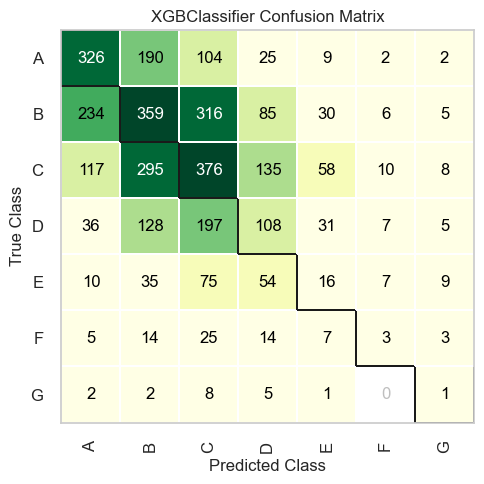

XGBClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.45      0.50      0.47       658
           B       0.35      0.35      0.35      1035
           C       0.34      0.38      0.36       999
           D       0.25      0.21      0.23       512
           E       0.11      0.08      0.09       206
           F       0.09      0.04      0.06        71
           G       0.03      0.05      0.04        19

    accuracy                           0.34      3500
   macro avg       0.23      0.23      0.23      3500
weighted avg       0.33      0.34      0.33      3500

Cross-validation
Accuracy scores: [0.33714286 0.34142857 0.34428571 0.36285714 0.33714286]
Accuracy score (average): 0.3445714285714286



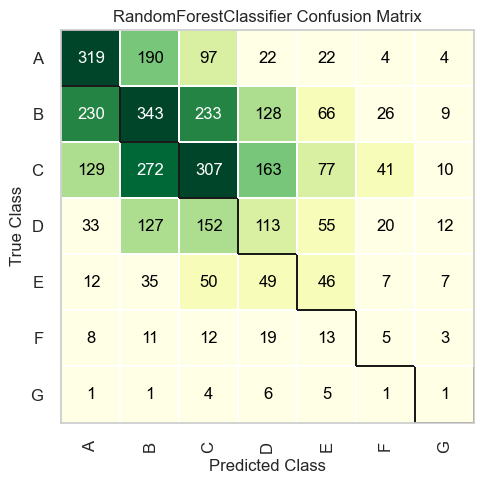

RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.44      0.48      0.46       658
           B       0.35      0.33      0.34      1035
           C       0.36      0.31      0.33       999
           D       0.23      0.22      0.22       512
           E       0.16      0.22      0.19       206
           F       0.05      0.07      0.06        71
           G       0.02      0.05      0.03        19

    accuracy                           0.32      3500
   macro avg       0.23      0.24      0.23      3500
weighted avg       0.33      0.32      0.33      3500

Cross-validation
Accuracy scores: [0.31714286 0.31428571 0.32       0.34       0.32571429]
Accuracy score (average): 0.3234285714285715



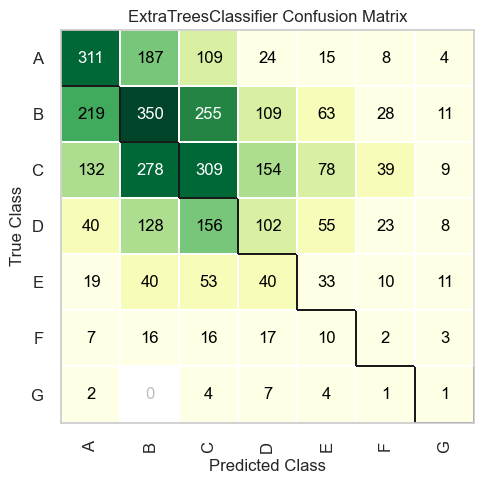

ExtraTreesClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.43      0.47      0.45       658
           B       0.35      0.34      0.34      1035
           C       0.34      0.31      0.33       999
           D       0.23      0.20      0.21       512
           E       0.13      0.16      0.14       206
           F       0.02      0.03      0.02        71
           G       0.02      0.05      0.03        19

    accuracy                           0.32      3500
   macro avg       0.22      0.22      0.22      3500
weighted avg       0.32      0.32      0.32      3500

Cross-validation
Accuracy scores: [0.31142857 0.29       0.32285714 0.35       0.32      ]
Accuracy score (average): 0.31885714285714284



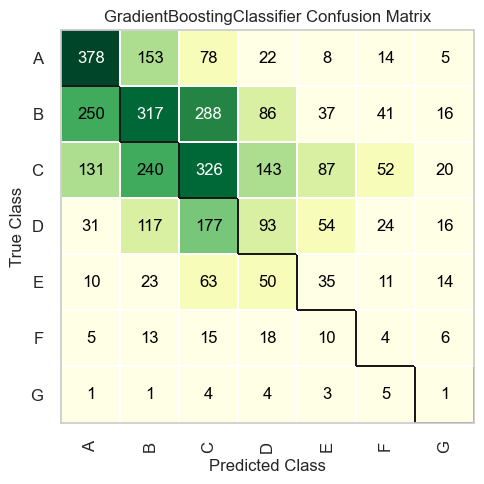

GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.47      0.57      0.52       658
           B       0.37      0.31      0.33      1035
           C       0.34      0.33      0.33       999
           D       0.22      0.18      0.20       512
           E       0.15      0.17      0.16       206
           F       0.03      0.06      0.04        71
           G       0.01      0.05      0.02        19

    accuracy                           0.33      3500
   macro avg       0.23      0.24      0.23      3500
weighted avg       0.34      0.33      0.33      3500

Cross-validation
Accuracy scores: [0.32142857 0.36714286 0.33857143 0.33428571 0.31285714]
Accuracy score (average): 0.33485714285714285



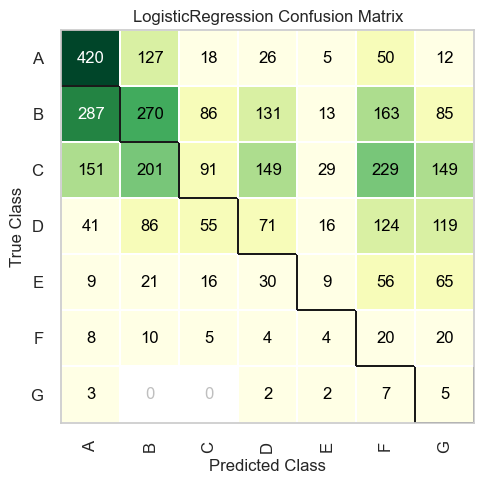

LogisticRegression
Classification Report:
              precision    recall  f1-score   support

           A       0.46      0.64      0.53       658
           B       0.38      0.26      0.31      1035
           C       0.34      0.09      0.14       999
           D       0.17      0.14      0.15       512
           E       0.12      0.04      0.06       206
           F       0.03      0.28      0.06        71
           G       0.01      0.26      0.02        19

    accuracy                           0.25      3500
   macro avg       0.21      0.25      0.18      3500
weighted avg       0.33      0.25      0.26      3500

Cross-validation
Accuracy scores: [0.27       0.26857143 0.26714286 0.25714286 0.24428571]
Accuracy score (average): 0.2614285714285714



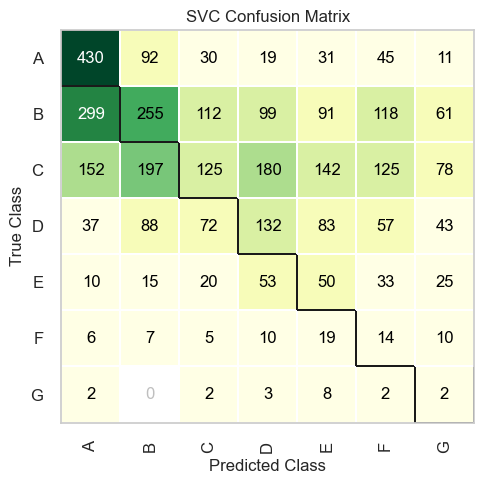

SVC
Classification Report:
              precision    recall  f1-score   support

           A       0.46      0.65      0.54       658
           B       0.39      0.25      0.30      1035
           C       0.34      0.13      0.18       999
           D       0.27      0.26      0.26       512
           E       0.12      0.24      0.16       206
           F       0.04      0.20      0.06        71
           G       0.01      0.11      0.02        19

    accuracy                           0.29      3500
   macro avg       0.23      0.26      0.22      3500
weighted avg       0.35      0.29      0.29      3500

Cross-validation
Accuracy scores: [0.26       0.29571429 0.25428571 0.27857143 0.28571429]
Accuracy score (average): 0.2748571428571428



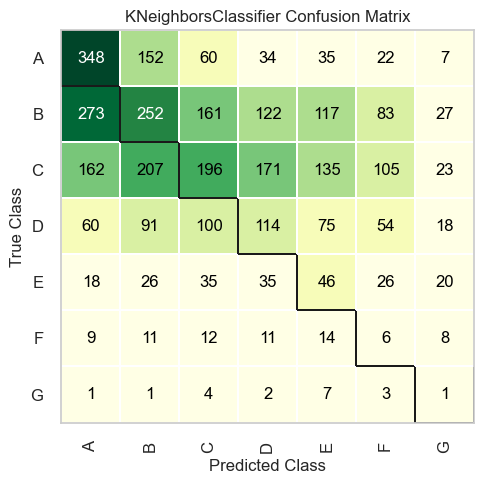

KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.40      0.53      0.46       658
           B       0.34      0.24      0.28      1035
           C       0.35      0.20      0.25       999
           D       0.23      0.22      0.23       512
           E       0.11      0.22      0.14       206
           F       0.02      0.08      0.03        71
           G       0.01      0.05      0.02        19

    accuracy                           0.28      3500
   macro avg       0.21      0.22      0.20      3500
weighted avg       0.32      0.28      0.28      3500

Cross-validation
Accuracy scores: [0.25142857 0.25857143 0.28714286 0.28428571 0.28857143]
Accuracy score (average): 0.274



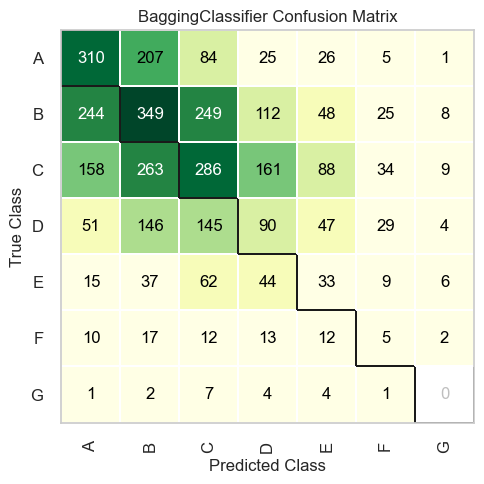

BaggingClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.39      0.47      0.43       658
           B       0.34      0.34      0.34      1035
           C       0.34      0.29      0.31       999
           D       0.20      0.18      0.19       512
           E       0.13      0.16      0.14       206
           F       0.05      0.07      0.06        71
           G       0.00      0.00      0.00        19

    accuracy                           0.31      3500
   macro avg       0.21      0.21      0.21      3500
weighted avg       0.31      0.31      0.31      3500

Cross-validation
Accuracy scores: [0.33142857 0.29571429 0.31285714 0.32428571 0.31857143]
Accuracy score (average): 0.31657142857142856



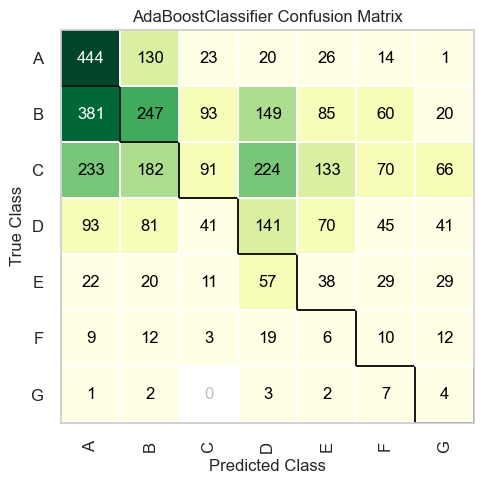

AdaBoostClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.38      0.67      0.48       658
           B       0.37      0.24      0.29      1035
           C       0.35      0.09      0.14       999
           D       0.23      0.28      0.25       512
           E       0.11      0.18      0.13       206
           F       0.04      0.14      0.07        71
           G       0.02      0.21      0.04        19

    accuracy                           0.28      3500
   macro avg       0.21      0.26      0.20      3500
weighted avg       0.32      0.28      0.26      3500

Cross-validation
Accuracy scores: [0.26428571 0.27714286 0.29       0.26142857 0.26571429]
Accuracy score (average): 0.27171428571428574



In [184]:
cross_vals = []
models = []
predictions = []
scores = {}
scores["precision_score"] = []
scores["recall_score"] = []
scores["model_name"] = []
scores["a_score"] = []
scores["f1_score"] = []
for classifier in classifiers:
    score_model(X_train, y_train, X_val, y_val, classifier, scores, models, classes_grade, size_grade)

In [83]:
scores = pd.DataFrame(scores)
scores = scores.set_index('model_name')
scores

,precision_score,recall_score,a_score,f1_score
model_name,,,,
XGBClassifier,0.249,0.247,0.382,0.247
RandomForestClassifier,0.247,0.245,0.369,0.244
ExtraTreesClassifier,0.229,0.226,0.353,0.226
GradientBoostingClassifier,0.246,0.251,0.372,0.248
LogisticRegression,0.242,0.274,0.311,0.228
SVC,0.253,0.277,0.355,0.258
KNeighborsClassifier,0.224,0.257,0.299,0.219
BaggingClassifier,0.222,0.226,0.338,0.223
AdaBoostClassifier,0.234,0.278,0.314,0.225


In [84]:
for model in models:
    joblib.dump(model, f'model{models.index(model)}.joblib')

In [86]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores.to_csv('scores_lending.csv')

In [87]:
scores = pd.DataFrame(scores).sort_values("a_score", ascending = False)

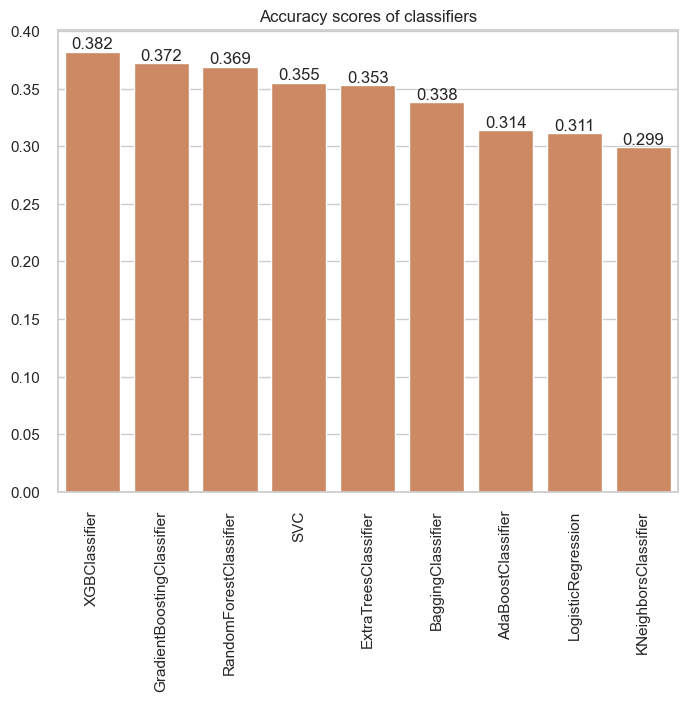

In [88]:
plot_bars(scores, "a_score", "", "Accuracy scores of classifiers")

It can be seen from the plot that the XgBoost classifier provides the highest accuracy score (0.382). This score is higher for just the random guessing (1/8 or 0.14). also, it can be seen that the models better predict 'A', 'B', and "C" grades (these grades are more often atributed to persons in the sample than others).

#### Feature importances

For the purpose of feature engeneering feature importances of ensemble classifiers were calculated and plotted. 

In [90]:
X_pipe = pd.DataFrame(preprocessor.fit_transform(X))
X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_pipe_val = pd.DataFrame(preprocessor.fit_transform(X_val))
X_pipe_test = pd.DataFrame(preprocessor.fit_transform(X_test))

In [91]:
smote = SMOTE()
X_resampled_train, y_resampled_train = smote.fit_resample(X_pipe_train, y_train)


In [92]:
preprocessor.get_feature_names_out()

array(['numeric__loan_amount', 'numeric__emp_length',
       'numeric__annual_inc', 'numeric__delinq_2yrs',
       'numeric__risk_score', 'numeric__inq_last_6mths',
       'numeric__pub_rec', 'numeric__revol_util', 'numeric__total_acc',
       'numeric__dti', 'numeric__acc_now_delinq',
       'numeric__chargeoff_within_12_mths', 'numeric__delinq_amnt',
       'numeric__pub_rec_bankruptcies',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period',
       'categorical__initial_list_status_f',
       'categorical__initial_list_status_w',
       'categorical__home_ownership_MORTGAGE',
       'categorical__home_ownership_OWN',
       'categorical__home_ownership_RENT', 'categorical__purpose_car',
       'categorical__purpose_credit_card',
       'categorical__purpose_debt_consolidation',
       'categorical__purpose_home_improvement',
       'categorical__purpos

In [93]:
X_pipe_train.columns = X_pipe_val.columns = X_pipe_test.columns = X_pipe.columns = X_resampled_train.columns =[
   'numeric__loan_amount', 'numeric__emp_length',
       'numeric__annual_inc', 'numeric__delinq_2yrs',
       'numeric__risk_score', 'numeric__inq_last_6mths',
       'numeric__pub_rec', 'numeric__revol_util', 'numeric__total_acc',
       'numeric__dti', 'numeric__acc_now_delinq',
       'numeric__chargeoff_within_12_mths', 'numeric__delinq_amnt',
       'numeric__pub_rec_bankruptcies',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period',
       'categorical__initial_list_status_f',
       'categorical__initial_list_status_w',
       'categorical__home_ownership_MORTGAGE',
       'categorical__home_ownership_OWN',
       'categorical__home_ownership_RENT', 'categorical__purpose_car',
       'categorical__purpose_credit_card',
       'categorical__purpose_debt_consolidation',
       'categorical__purpose_home_improvement',
       'categorical__purpose_major_purchase',
       'categorical__purpose_medical', 'categorical__purpose_moving',
       'categorical__purpose_other',
       'categorical__purpose_small_business',
       'categorical__purpose_vacation',
       'categorical__verification_status_Not Verified',
       'categorical__verification_status_Source Verified',
       'categorical__verification_status_Verified']

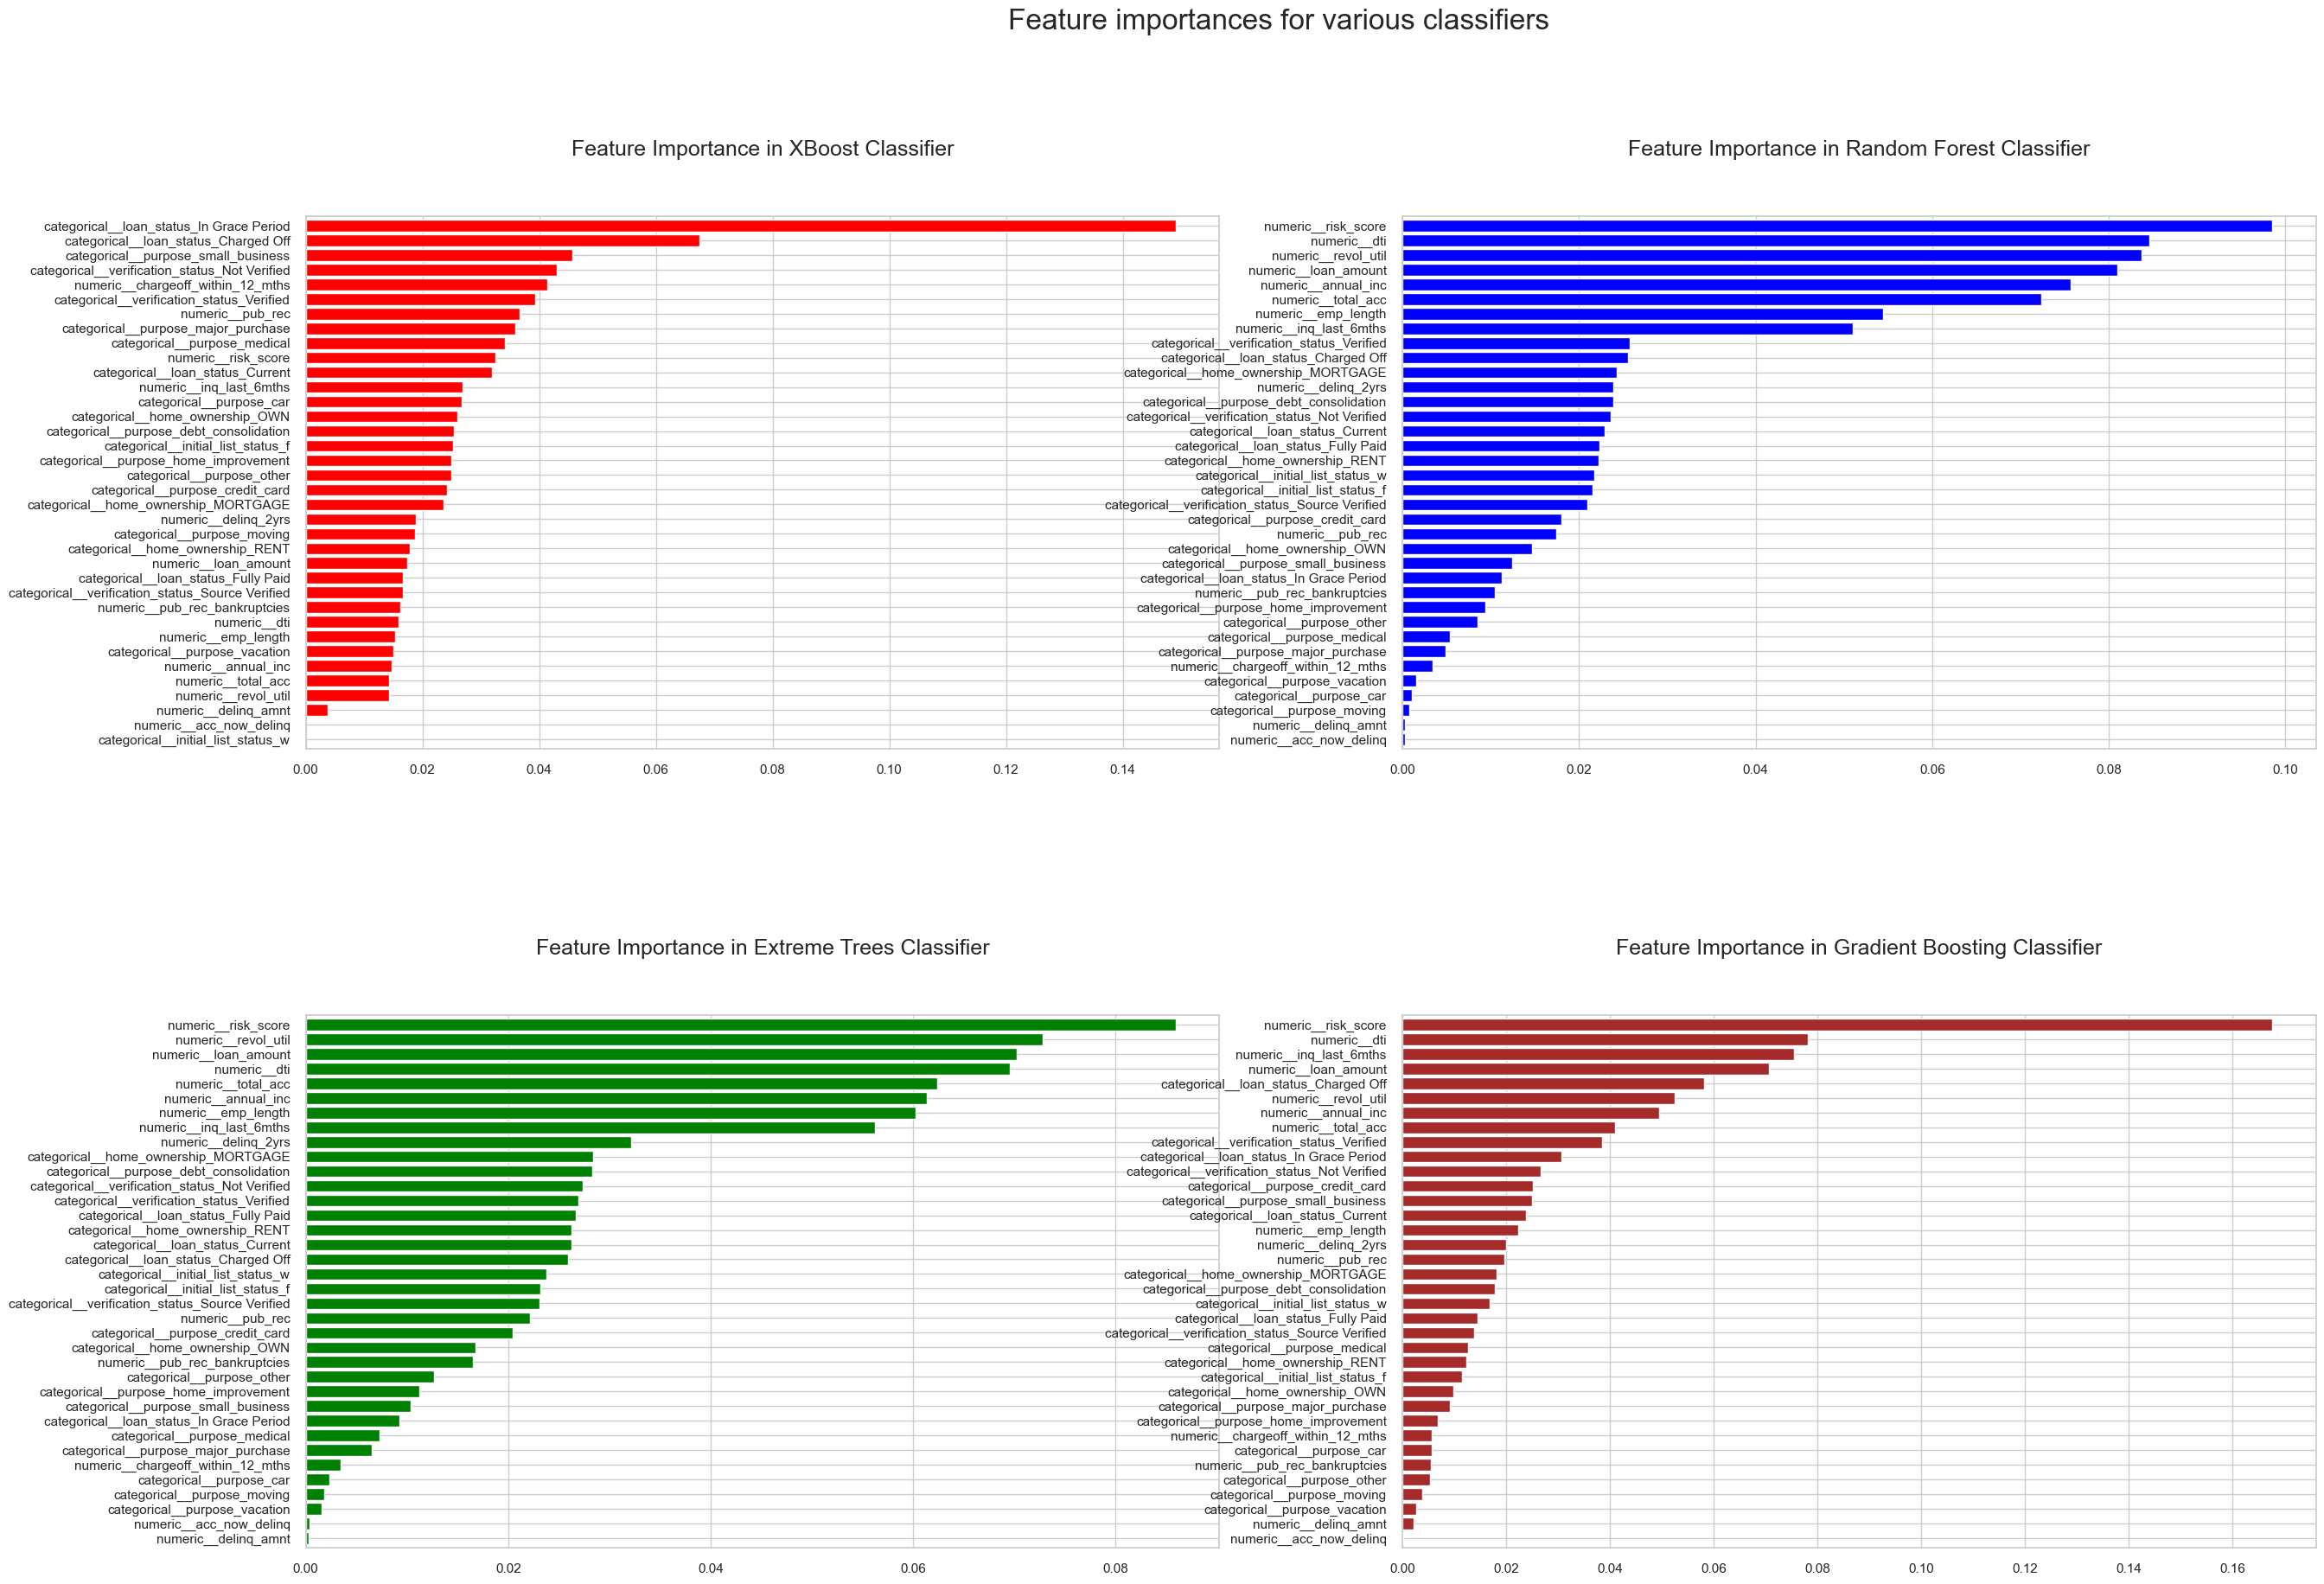

In [94]:
indices = [0, 1, 2, 3]
models_new = [models[index] for index in indices]
model_list = ['XBoost Classifier', 'Random Forest Classifier','Extreme Trees Classifier',
              'Gradient Boosting Classifier']
color_list = ['red','blue','green','brown']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Feature importances for various classifiers", fontsize=24, y=1)

for model, ax in zip(models_new, axs.ravel()):
    pd.Series(model[2].feature_importances_, index = X_pipe_train.columns).\
    sort_values(ascending=True).plot.barh(width=0.8,ax = ax,color=color_list[models_new.index(model)])
    ax.set_title(f'Feature Importance in {model_list[models_new.index(model)]}', fontsize=18, y=1.1)
    ax.set_xlabel("")

plt.show()

#### Feature selection based on feature importances

Features for further analysis were seleced in two ways: 1) by examining feature importances and selecting the most important features; 2) by selecting features manually.

##### 1) Feature selection after encoding

The list of feature names sorted by feature importances from was obtained. 

In [98]:
pd.DataFrame(models[3][2].feature_importances_, index = X_pipe_val.columns).sort_values(0, ascending = False)

,0
numeric__risk_score,0.167680
numeric__dti,0.078169
numeric__inq_last_6mths,0.075523
numeric__loan_amount,0.070735
categorical__loan_status_Charged Off,0.058124
numeric__revol_util,0.052500
numeric__annual_inc,0.049499
numeric__total_acc,0.041008
categorical__verification_status_Verified,0.038541
categorical__loan_status_In Grace Period,0.030690


Features were selected from arbitrary limit (features with importances lower thatn this limit were not included).

In [99]:
features_selected_df = pd.DataFrame(models[0][2].\
                                    feature_importances_, index = X_pipe_val.columns).\
                                    sort_values(0, ascending = False).loc[:"numeric__delinq_2yrs",:]

The list of feature names was obtained.

In [100]:
columns_list = []
for col in X_pipe_train.columns.tolist():
    if col in features_selected_df.transpose().columns.tolist():
        columns_list.append(X_pipe_train.columns.tolist().index(col))
    else:
        pass
    

Data with these feature names were selected from train, validation and test datasets.

In [101]:
X_resampled_train_select = X_resampled_train.iloc[:,columns_list]
X_pipe_val_select =  X_pipe_val.iloc[:,columns_list]
X_pipe_test_select = X_pipe_test.iloc[:,columns_list]

The function to run preprocessed data outside the pipeline on classifiers was created. 

In [103]:
def score_model_no_pipeline(x_train, y_train, x_val, y_val, estimator, df, models_list, classes, size, **kwargs):
    
    # Model fitting and prediction:
    model = classifier.fit(x_train, y_train)
    prediction = model.predict(x_val)
    
    # Cross-validation:
    scoring = {'accuracy': make_scorer(accuracy_score)}
    cross_val = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    cross_vals.append(cross_val)
    accuracy_scores = cross_val['test_accuracy']
    
    #Metrics:
    f1 = f1_score(y_val, prediction, average='macro').round(3)
    prec = precision_score(y_val, prediction, average='macro').round(3)
    rec = recall_score(y_val, prediction, average='macro').round(3)
    acc_sq = accuracy_score(y_val, prediction).round(3)
    
    conf = confusion_matrix(model, x_train, y_train, x_val, y_val, classes=classes,
        cmap="YlGn", size=size, **kwargs)
    report = classification_report(y_val, prediction, target_names=classes)
    
    #Prints:
    print (estimator.__class__.__name__)
    print("Classification Report:")
    print(report)
    print (f'Cross-validation')
    print ("Accuracy scores: {}".format(accuracy_scores))
    avg_list = sum(list(accuracy_scores))/len(list(accuracy_scores))
    print (f"Accuracy score (average): {avg_list}")
    print('')
    
    #Appends:
    models_list.append(model)
    predictions.append(prediction)
    df["model_name"].append(f'{estimator.__class__.__name__}')
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)

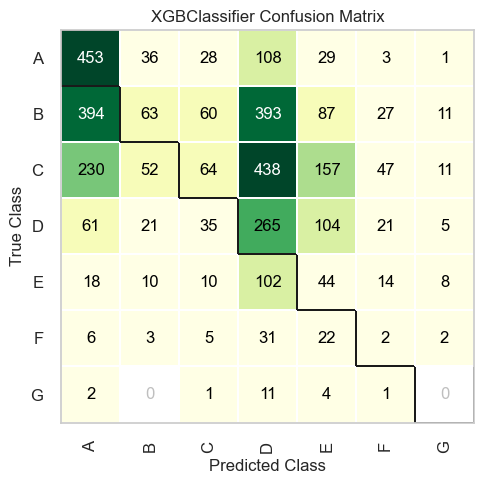

XGBClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.39      0.69      0.50       658
           B       0.34      0.06      0.10      1035
           C       0.32      0.06      0.11       999
           D       0.20      0.52      0.28       512
           E       0.10      0.21      0.13       206
           F       0.02      0.03      0.02        71
           G       0.00      0.00      0.00        19

    accuracy                           0.25      3500
   macro avg       0.19      0.22      0.16      3500
weighted avg       0.30      0.25      0.20      3500

Cross-validation
Accuracy scores: [0.46339779 0.60290055 0.61464088 0.67311679 0.66689703]
Accuracy score (average): 0.6041906096438812



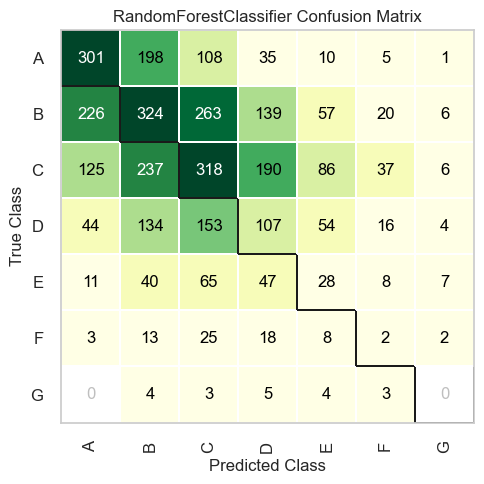

RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.42      0.46      0.44       658
           B       0.34      0.31      0.33      1035
           C       0.34      0.32      0.33       999
           D       0.20      0.21      0.20       512
           E       0.11      0.14      0.12       206
           F       0.02      0.03      0.02        71
           G       0.00      0.00      0.00        19

    accuracy                           0.31      3500
   macro avg       0.21      0.21      0.21      3500
weighted avg       0.31      0.31      0.31      3500

Cross-validation
Accuracy scores: [0.48687845 0.59944751 0.62016575 0.69039392 0.68002764]
Accuracy score (average): 0.6153826549118581



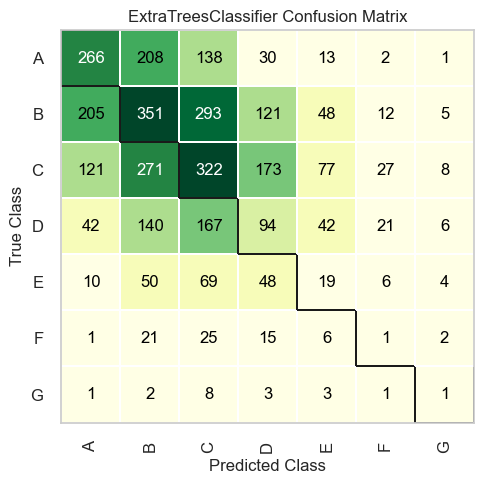

ExtraTreesClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.41      0.40      0.41       658
           B       0.34      0.34      0.34      1035
           C       0.32      0.32      0.32       999
           D       0.19      0.18      0.19       512
           E       0.09      0.09      0.09       206
           F       0.01      0.01      0.01        71
           G       0.04      0.05      0.04        19

    accuracy                           0.30      3500
   macro avg       0.20      0.20      0.20      3500
weighted avg       0.30      0.30      0.30      3500

Cross-validation
Accuracy scores: [0.51104972 0.60773481 0.61533149 0.69937802 0.67519005]
Accuracy score (average): 0.6217368187944575



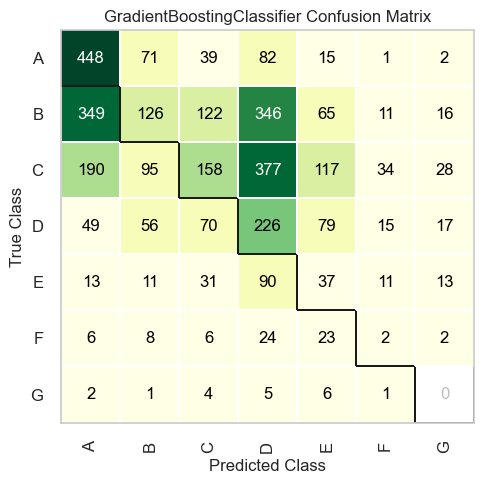

GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.42      0.68      0.52       658
           B       0.34      0.12      0.18      1035
           C       0.37      0.16      0.22       999
           D       0.20      0.44      0.27       512
           E       0.11      0.18      0.14       206
           F       0.03      0.03      0.03        71
           G       0.00      0.00      0.00        19

    accuracy                           0.28      3500
   macro avg       0.21      0.23      0.19      3500
weighted avg       0.32      0.28      0.26      3500

Cross-validation
Accuracy scores: [0.44544199 0.55662983 0.56422652 0.60677263 0.58811334]
Accuracy score (average): 0.5522368627031733



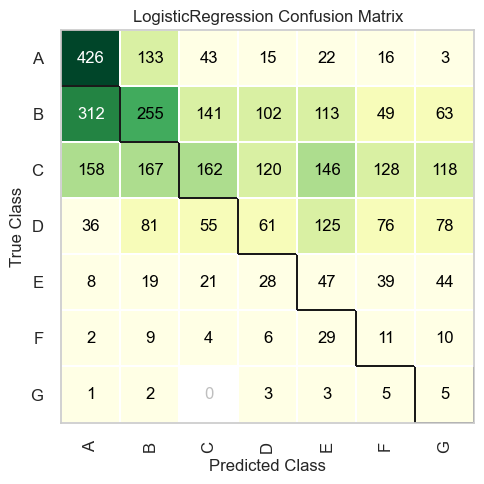

LogisticRegression
Classification Report:
              precision    recall  f1-score   support

           A       0.45      0.65      0.53       658
           B       0.38      0.25      0.30      1035
           C       0.38      0.16      0.23       999
           D       0.18      0.12      0.14       512
           E       0.10      0.23      0.14       206
           F       0.03      0.15      0.06        71
           G       0.02      0.26      0.03        19

    accuracy                           0.28      3500
   macro avg       0.22      0.26      0.20      3500
weighted avg       0.34      0.28      0.28      3500

Cross-validation
Accuracy scores: [0.36533149 0.39709945 0.38535912 0.40152039 0.39875605]
Accuracy score (average): 0.3896132978500002



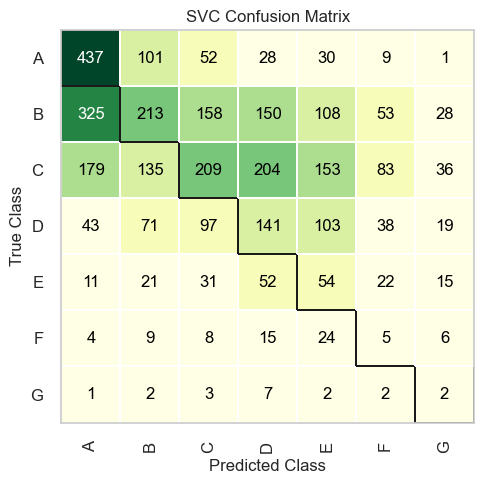

SVC
Classification Report:
              precision    recall  f1-score   support

           A       0.44      0.66      0.53       658
           B       0.39      0.21      0.27      1035
           C       0.37      0.21      0.27       999
           D       0.24      0.28      0.25       512
           E       0.11      0.26      0.16       206
           F       0.02      0.07      0.04        71
           G       0.02      0.11      0.03        19

    accuracy                           0.30      3500
   macro avg       0.23      0.26      0.22      3500
weighted avg       0.35      0.30      0.30      3500

Cross-validation
Accuracy scores: [0.5359116  0.55524862 0.56353591 0.57221838 0.56185211]
Accuracy score (average): 0.5577533246534075



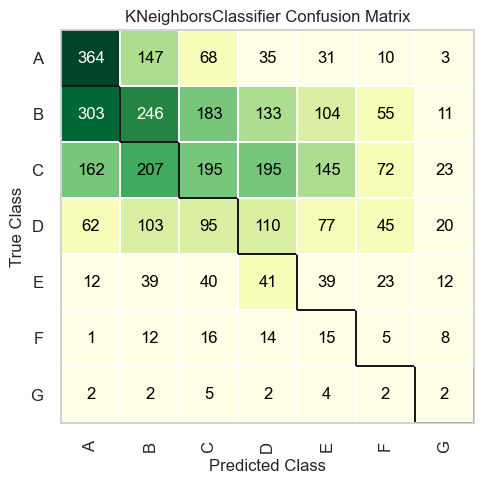

KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.40      0.55      0.47       658
           B       0.33      0.24      0.27      1035
           C       0.32      0.20      0.24       999
           D       0.21      0.21      0.21       512
           E       0.09      0.19      0.13       206
           F       0.02      0.07      0.04        71
           G       0.03      0.11      0.04        19

    accuracy                           0.27      3500
   macro avg       0.20      0.22      0.20      3500
weighted avg       0.30      0.27      0.28      3500

Cross-validation
Accuracy scores: [0.57320442 0.60842541 0.60980663 0.63303386 0.63026952]
Accuracy score (average): 0.6109479700809829



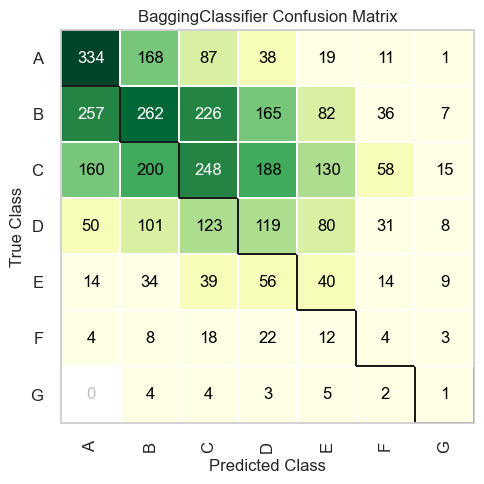

BaggingClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.41      0.51      0.45       658
           B       0.34      0.25      0.29      1035
           C       0.33      0.25      0.28       999
           D       0.20      0.23      0.22       512
           E       0.11      0.19      0.14       206
           F       0.03      0.06      0.04        71
           G       0.02      0.05      0.03        19

    accuracy                           0.29      3500
   macro avg       0.21      0.22      0.21      3500
weighted avg       0.31      0.29      0.29      3500

Cross-validation
Accuracy scores: [0.46546961 0.57665746 0.60566298 0.65307533 0.64340014]
Accuracy score (average): 0.5888531043461993



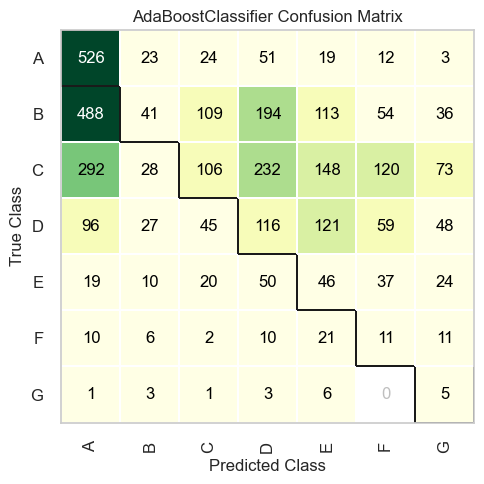

AdaBoostClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.37      0.80      0.50       658
           B       0.30      0.04      0.07      1035
           C       0.35      0.11      0.16       999
           D       0.18      0.23      0.20       512
           E       0.10      0.22      0.14       206
           F       0.04      0.15      0.06        71
           G       0.03      0.26      0.05        19

    accuracy                           0.24      3500
   macro avg       0.19      0.26      0.17      3500
weighted avg       0.29      0.24      0.20      3500

Cross-validation
Accuracy scores: [0.3218232  0.38535912 0.37569061 0.38286109 0.3731859 ]
Accuracy score (average): 0.3677839843914061



In [115]:
cross_vals = []
models_selected1 = []
predictions = []
scores_selected1 = {}
scores_selected1["precision_score"] = []
scores_selected1["recall_score"] = []
scores_selected1["model_name"] = []
scores_selected1["a_score"] = []
scores_selected1["f1_score"] = []
for classifier in classifiers:
    score_model_no_pipeline(X_resampled_train_select, y_resampled_train, X_pipe_val_select, y_val, 
                            classifier, scores_selected1, models_selected1, classes_grade, size_grade)


In [117]:
scores_selected1 = pd.DataFrame(scores_selected1)
scores_selected1 = scores_selected1.set_index('model_name')
scores_selected1

,precision_score,recall_score,a_score,f1_score
model_name,,,,
XGBClassifier,0.194,0.225,0.255,0.164
RandomForestClassifier,0.205,0.209,0.309,0.207
ExtraTreesClassifier,0.200,0.201,0.301,0.200
GradientBoostingClassifier,0.209,0.230,0.285,0.194
LogisticRegression,0.220,0.260,0.276,0.204
SVC,0.227,0.256,0.303,0.221
KNeighborsClassifier,0.200,0.224,0.275,0.200
BaggingClassifier,0.205,0.221,0.288,0.207
AdaBoostClassifier,0.192,0.259,0.243,0.168


In [118]:
for model in models_selected1:
    joblib.dump(model, f'model{models_selected1.index(model)}.joblib')

In [119]:
#scores_selected1 = pd.DataFrame(scores_selected1).set_index("model_name")
scores_selected1.to_csv('scores_selected1.csv')

In [120]:
scores_selected1 = pd.DataFrame(scores_selected1).sort_values("a_score", ascending = False)

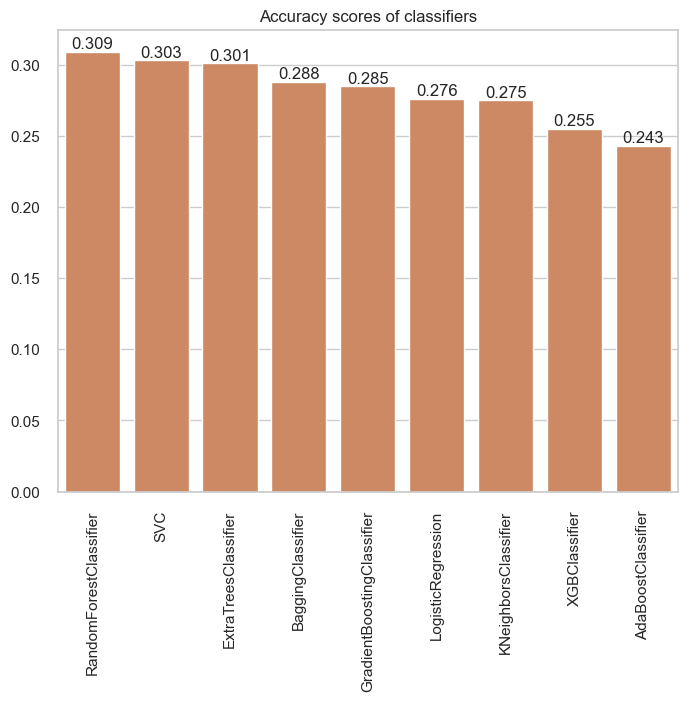

In [121]:
plot_bars(scores_selected1, "a_score", "", "Accuracy scores of classifiers")

It can be seen from the plot that the scores are a bit lower than in the initial set of features. Th random forest classifier provides the highest accuracy score. However, accuracy scores calculated for training data (cross-validation) are much higher. 

##### 1) Manual feature selection for pipeline

For this approach, numerical features which generated high scores for machine learning models predicting request status (see the II part) were selected and a categorical variable which had statistical significant impact on 'grade' variable (chi square test result) was selected

In [122]:
num_feature_list = ['emp_length', 'risk_score','loan_amount', 'dti']
cat_feature_list = ['loan_status']


The function for feature selecting and including into preprocessor was created.

In [123]:
def feature_selector_for_preprocessor(num_feature_list, cat_feature_list):
    numeric_features_selected = num_feature_list
    categorical_features_selected = cat_feature_list
    preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_features_selected),
        ('categorical', categorical_transformer, categorical_features_selected),
    ])
    return preprocessor

In [124]:
preprocessor = feature_selector_for_preprocessor(num_feature_list, cat_feature_list)

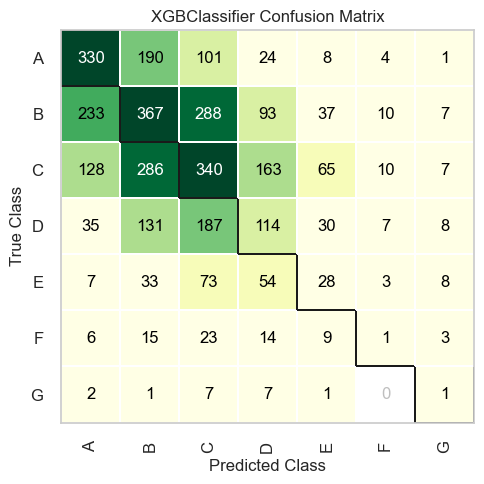

XGBClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.45      0.50      0.47       658
           B       0.36      0.35      0.36      1035
           C       0.33      0.34      0.34       999
           D       0.24      0.22      0.23       512
           E       0.16      0.14      0.15       206
           F       0.03      0.01      0.02        71
           G       0.03      0.05      0.04        19

    accuracy                           0.34      3500
   macro avg       0.23      0.23      0.23      3500
weighted avg       0.33      0.34      0.33      3500

Cross-validation
Accuracy scores: [0.33571429 0.32571429 0.34571429 0.35714286 0.34714286]
Accuracy score (average): 0.3422857142857143



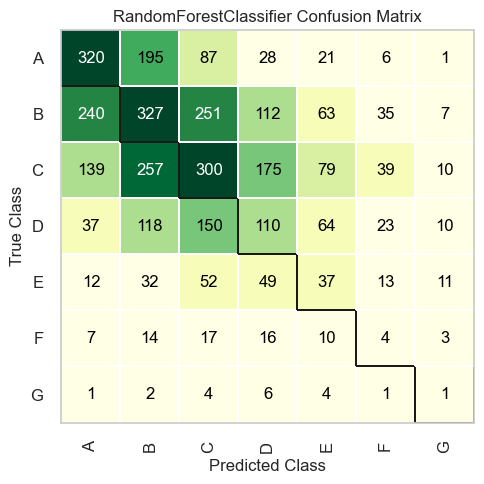

RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.42      0.49      0.45       658
           B       0.35      0.32      0.33      1035
           C       0.35      0.30      0.32       999
           D       0.22      0.21      0.22       512
           E       0.13      0.18      0.15       206
           F       0.03      0.06      0.04        71
           G       0.02      0.05      0.03        19

    accuracy                           0.31      3500
   macro avg       0.22      0.23      0.22      3500
weighted avg       0.32      0.31      0.32      3500

Cross-validation
Accuracy scores: [0.31857143 0.31571429 0.32714286 0.35       0.32285714]
Accuracy score (average): 0.32685714285714285



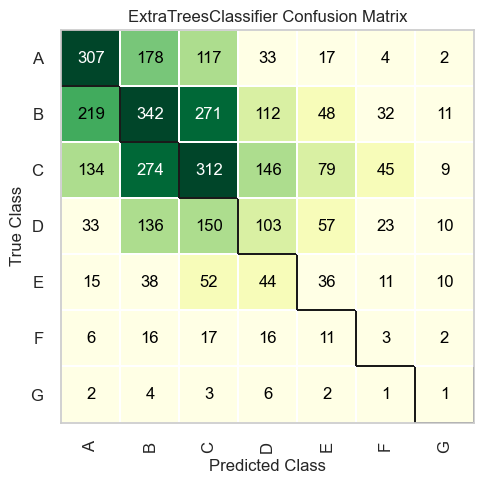

ExtraTreesClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.43      0.47      0.45       658
           B       0.35      0.33      0.34      1035
           C       0.34      0.31      0.32       999
           D       0.22      0.20      0.21       512
           E       0.14      0.17      0.16       206
           F       0.03      0.04      0.03        71
           G       0.02      0.05      0.03        19

    accuracy                           0.32      3500
   macro avg       0.22      0.23      0.22      3500
weighted avg       0.32      0.32      0.32      3500

Cross-validation
Accuracy scores: [0.31142857 0.3        0.33428571 0.34285714 0.32285714]
Accuracy score (average): 0.32228571428571434



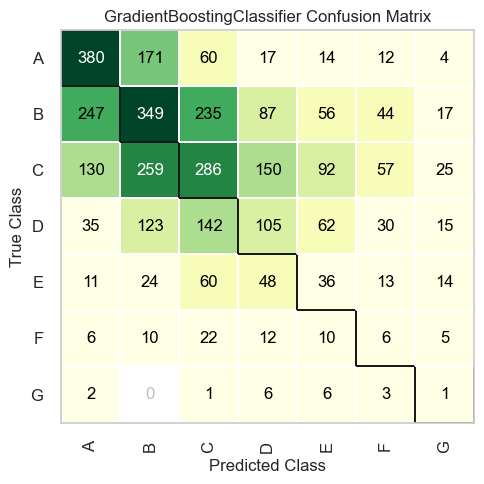

GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.47      0.58      0.52       658
           B       0.37      0.34      0.35      1035
           C       0.35      0.29      0.32       999
           D       0.25      0.21      0.22       512
           E       0.13      0.17      0.15       206
           F       0.04      0.08      0.05        71
           G       0.01      0.05      0.02        19

    accuracy                           0.33      3500
   macro avg       0.23      0.25      0.23      3500
weighted avg       0.34      0.33      0.34      3500

Cross-validation
Accuracy scores: [0.31857143 0.36285714 0.33571429 0.35142857 0.28857143]
Accuracy score (average): 0.3314285714285714



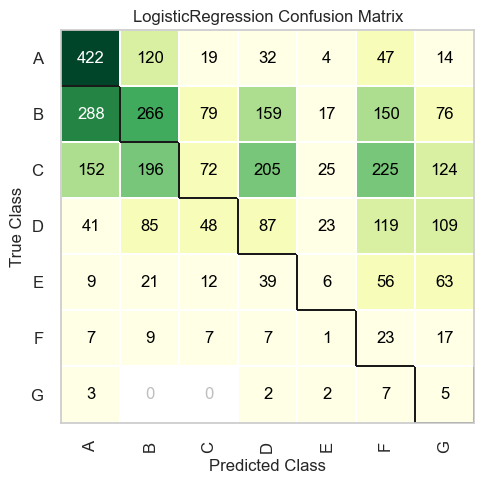

LogisticRegression
Classification Report:
              precision    recall  f1-score   support

           A       0.46      0.64      0.53       658
           B       0.38      0.26      0.31      1035
           C       0.30      0.07      0.12       999
           D       0.16      0.17      0.17       512
           E       0.08      0.03      0.04       206
           F       0.04      0.32      0.07        71
           G       0.01      0.26      0.02        19

    accuracy                           0.25      3500
   macro avg       0.20      0.25      0.18      3500
weighted avg       0.31      0.25      0.25      3500

Cross-validation
Accuracy scores: [0.26714286 0.26       0.26       0.26142857 0.22857143]
Accuracy score (average): 0.25542857142857145



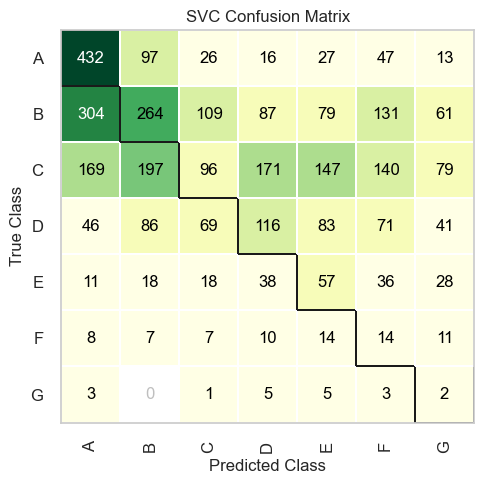

SVC
Classification Report:
              precision    recall  f1-score   support

           A       0.44      0.66      0.53       658
           B       0.39      0.26      0.31      1035
           C       0.29      0.10      0.14       999
           D       0.26      0.23      0.24       512
           E       0.14      0.28      0.18       206
           F       0.03      0.20      0.05        71
           G       0.01      0.11      0.02        19

    accuracy                           0.28      3500
   macro avg       0.22      0.26      0.21      3500
weighted avg       0.33      0.28      0.28      3500

Cross-validation
Accuracy scores: [0.25714286 0.29571429 0.28285714 0.27571429 0.27571429]
Accuracy score (average): 0.2774285714285714



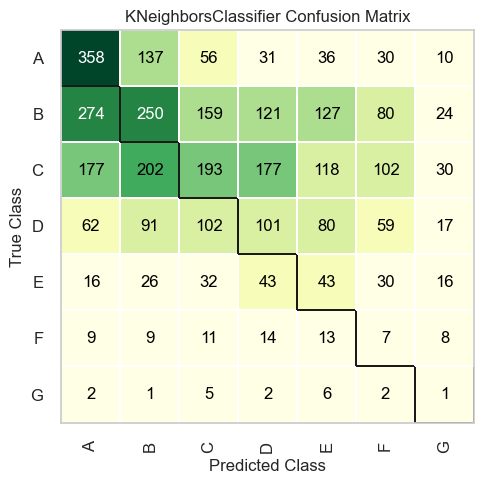

KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.40      0.54      0.46       658
           B       0.35      0.24      0.29      1035
           C       0.35      0.19      0.25       999
           D       0.21      0.20      0.20       512
           E       0.10      0.21      0.14       206
           F       0.02      0.10      0.04        71
           G       0.01      0.05      0.02        19

    accuracy                           0.27      3500
   macro avg       0.20      0.22      0.20      3500
weighted avg       0.31      0.27      0.28      3500

Cross-validation
Accuracy scores: [0.27285714 0.26714286 0.28428571 0.27142857 0.28714286]
Accuracy score (average): 0.2765714285714286



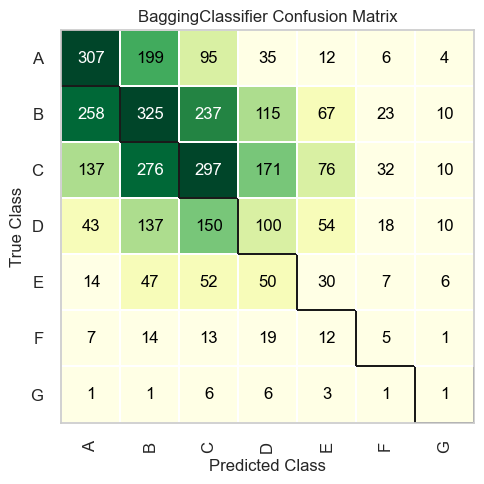

BaggingClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.40      0.47      0.43       658
           B       0.33      0.31      0.32      1035
           C       0.35      0.30      0.32       999
           D       0.20      0.20      0.20       512
           E       0.12      0.15      0.13       206
           F       0.05      0.07      0.06        71
           G       0.02      0.05      0.03        19

    accuracy                           0.30      3500
   macro avg       0.21      0.22      0.21      3500
weighted avg       0.31      0.30      0.31      3500

Cross-validation
Accuracy scores: [0.30714286 0.31       0.31857143 0.31714286 0.32857143]
Accuracy score (average): 0.3162857142857143



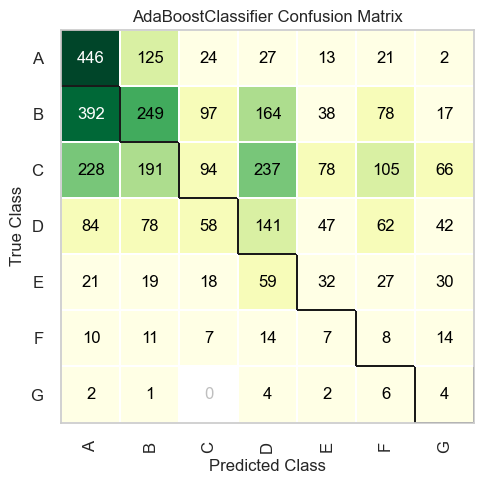

AdaBoostClassifier
Classification Report:
              precision    recall  f1-score   support

           A       0.38      0.68      0.48       658
           B       0.37      0.24      0.29      1035
           C       0.32      0.09      0.14       999
           D       0.22      0.28      0.24       512
           E       0.15      0.16      0.15       206
           F       0.03      0.11      0.04        71
           G       0.02      0.21      0.04        19

    accuracy                           0.28      3500
   macro avg       0.21      0.25      0.20      3500
weighted avg       0.31      0.28      0.26      3500

Cross-validation
Accuracy scores: [0.23857143 0.28142857 0.29428571 0.25714286 0.25571429]
Accuracy score (average): 0.26542857142857146



In [126]:
cross_vals = []
models_selected = []
predictions = []
scores_selected = {}
scores_selected["precision_score"] = []
scores_selected["recall_score"] = []
scores_selected["model_name"] = []
scores_selected["a_score"] = []
scores_selected["f1_score"] = []
for classifier in classifiers:
    score_model(X_train, y_train, X_val, y_val, classifier, scores_selected, 
                models_selected, classes_grade, size_grade)

In [127]:
scores_selected = pd.DataFrame(scores_selected)
scores_selected = scores_selected.set_index('model_name')
scores_selected

,precision_score,recall_score,a_score,f1_score
model_name,,,,
XGBClassifier,0.228,0.232,0.337,0.229
RandomForestClassifier,0.218,0.229,0.314,0.222
ExtraTreesClassifier,0.218,0.226,0.315,0.220
GradientBoostingClassifier,0.232,0.245,0.332,0.233
LogisticRegression,0.205,0.251,0.252,0.179
SVC,0.225,0.259,0.280,0.212
KNeighborsClassifier,0.205,0.219,0.272,0.198
BaggingClassifier,0.210,0.220,0.304,0.214
AdaBoostClassifier,0.211,0.252,0.278,0.200


In [128]:
for model in models_selected:
    joblib.dump(model, f'model_selected{models_selected.index(model)}.joblib')

In [129]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores_selected.to_csv('scores_lending_selected.csv')

In [130]:
scores_selected = pd.DataFrame(scores_selected).sort_values("a_score", ascending = False)

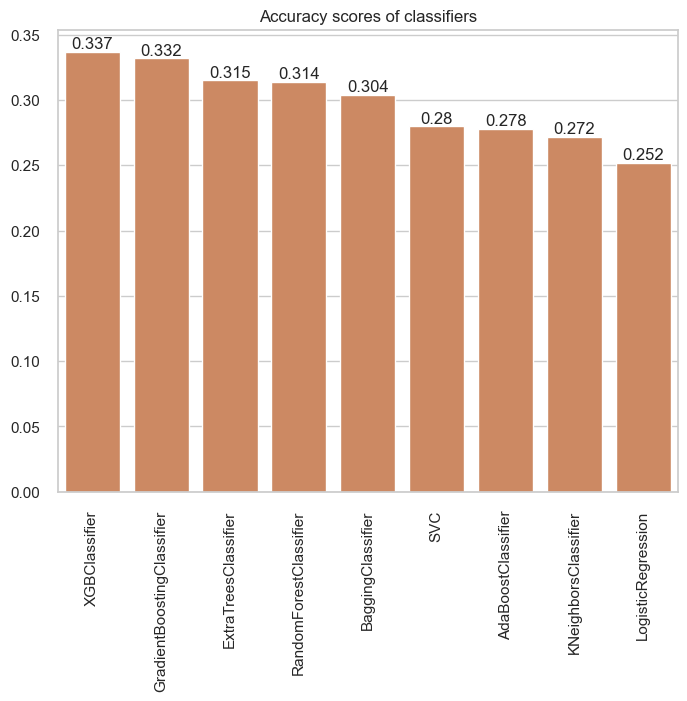

In [131]:
plot_bars(scores_selected, "a_score", "", "Accuracy scores of classifiers")

It can be seen that the scores for the initial list of features are higher comparing with the scores after feature selection. The combination of features selected manually still gives quite good scores which are higher than scores after selecting features by feature importances.

#### Hyperparameter tuning - Bayesian optimization

Hyperparameter tuning with the Bayesian optimization was performed for the dataset with features selected manually. For that purpose it was needed to get preprocessed and resampled datasets.

In [133]:
X_pipe = pd.DataFrame(preprocessor.fit_transform(X))
X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_pipe_val = pd.DataFrame(preprocessor.fit_transform(X_val))
X_pipe_test = pd.DataFrame(preprocessor.fit_transform(X_test))

In [135]:
smote = SMOTE()
X_resampled_train, y_resampled_train = smote.fit_resample(X_pipe_train, y_train)


In [152]:
preprocessor.get_feature_names_out()

array(['numeric__emp_length', 'numeric__risk_score',
       'numeric__loan_amount', 'numeric__dti',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period'], dtype=object)

In [153]:
X_pipe_train.columns = X_pipe_val.columns = X_pipe_test.columns = X_pipe.columns = ['numeric__emp_length', 
        'numeric__risk_score',
       'numeric__loan_amount', 'numeric__dti',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period']

In [136]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGB', 'RF', 'ET', 'GB', 'LR', 'SVC', 'KNN', 'Bagging', 'AdaBoost'])

    if classifier_name == 'XGB':
        classifier = xgb.XGBClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,1000, step = 100),
        max_depth = trial.suggest_int('max_depth', 3, 9, step = 3),
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
        subsample = trial.suggest_float('subsample', 0.6, 1, step = 0.2)
        )
        classifier.fit(X_resampled_train, y_resampled_train)

    elif classifier_name == 'RF':
        classifier = RandomForestClassifier(
        n_estimators = trial.suggest_int("n_estimators", 10,101, step = 10),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
        max_samples = trial.suggest_float("max_samples",0.2, 1),
        random_state = 42
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'ET':
        classifier = ExtraTreesClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
        max_depth = trial.suggest_int('max_depth',1, 9, step = 4),
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'GB':
        classifier = GradientBoostingClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log = True)
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'LR':
        classifier = LogisticRegression(
            C=trial.suggest_float('C', 1, 9, step = 4),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga'])
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'SVC':
        classifier = SVC(
            C=trial.suggest_float('C', 1, 9, step = 4),
            kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
            gamma=trial.suggest_categorical('gamma', ['scale', 'auto'])
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'KNN':
        classifier = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 7, step = 2),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            leaf_size=trial.suggest_int('leaf_size', 30, 90, step = 30)
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'Bagging':
        classifier = BaggingClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 90, step = 20),
            max_samples=trial.suggest_float('max_samples', 0.5, 0.9, step = 0.2),
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    else:
        classifier = AdaBoostClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 200, step = 50),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 10.0, log = True)
        )
        classifier.fit(X_resampled_train, y_resampled_train)
    
    y_pred = classifier.predict(X_pipe_val)
    score = accuracy_score(y_val, y_pred)

    return score


In [138]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best Score:  0.31657142857142856
Best Params: 
  classifier: ET
  n_estimators: 500
  max_depth: 5


#### Predicting values and evaluating tuned models on the test dataset

The model tuned by the Bayesian optimization was tested on the test data. 

##### For a model tuned by the Bayesian optimization:

ExtraTreesClassifier


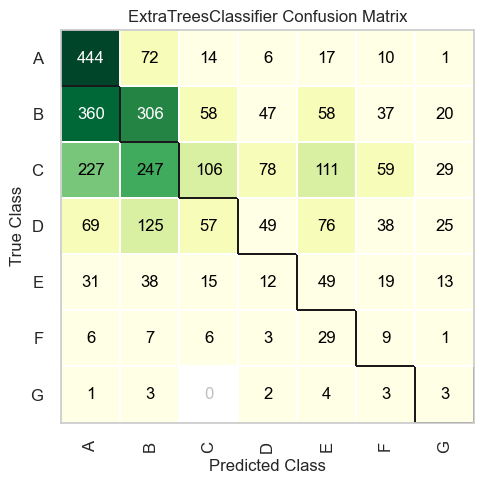

Accuracy score: 0.322
F1 score: 0.221
Precision: 0.238
Recall: 0.283


In [148]:
model = ExtraTreesClassifier(n_estimators =500, max_depth = 5).fit(X_resampled_train, y_resampled_train)
prediction = model.predict(X_pipe_test)

# Metrics:
prec = precision_score(y_test, prediction, average='macro').round(3)
rec = recall_score(y_test, prediction, average='macro').round(3)
acc_sq = accuracy_score(y_test, prediction).round(3)
f1 = f1_score(y_test, prediction, average='macro').round(3)

#Prints:
print (model.__class__.__name__)
conf = confusion_matrix(
    model, X_resampled_train, y_train, X_pipe_test, y_test, classes=classes_grade,
    cmap="YlGn", size=size_grade)
print (f"Accuracy score: {acc_sq}")
print (f"F1 score: {f1}")
print (f"Precision: {prec}")
print (f"Recall: {rec}")

In [1]:
joblib.dump(model, 'best_model_grade.joblib')

NameError: name 'joblib' is not defined

It can be seen that the ExtraTree classifier performs similarly on the test data as on the validation data. This model will be used for the prediction based on the user input data.

#### Using the selected model for prediction

In [ ]:
model = joblib.load('best_model_grade.joblib')

In [162]:
inp1 = int(input("How many years has the applicant been employed?: "))
inp2 = float(input("What is the risk score of the applicant?: "))
inp3 = int(input("What is the loan amount the applicant requested?: "))
inp4 = float(input("What is the debt-to-income ratio of the applicant?: "))
inp5 = int(input("What is the applicant charged off? 0 - No; 1 - Yes: "))
inp6 = int(input("What is the applicant current receiver of a loan? 0 - No; 1 - Yes: "))
inp7 = int(input("What is the applicant fully paid? 0 - No; 1 - Yes: "))
inp8 = int(input("What is the applicant in grace period? 0 - No; 1 - Yes: "))

How many years has the applicant been employed?: 10
What is the risk score of the applicant?: 700
What is the loan amount the applicant requested?: 4000
What is the debt-to-income ratio of the applicant?: 20
What is the applicant charged off? 0 - No; 1 - Yes: 1
What is the applicant current receiver of a loan? 0 - No; 1 - Yes: 0
What is the applicant fully paid? 0 - No; 1 - Yes: 0
What is the applicant in grace period? 0 - No; 1 - Yes: 0


In [163]:
X_prediction = X_pipe_test.copy()

In [164]:
X_prediction.loc[len(X_prediction.index)] = [inp1, inp2, inp3, inp4, inp5, inp6, inp7, inp8] 

In [165]:
len(X_prediction)

3001

In [183]:
prob = []
pred = []
prob = model.predict_proba(X_prediction)
pred = model.predict(X_prediction)

print(f' It is predicted that the applicants grade is {[k for k, v in name_mapping.items() if v == pred[3000]]}.')

 It is predicted that the applicants grade is ['C'].


### Conclusions for the III part

From this part of the analysis it can be concluded:
   1. Grades of persons whose loan applications are accepted can be predicted with such features as:
   
   - employment length (persons with the longer employment length will get higher grade);
   
   - risk score (persons whose risk score is higher will get higher grade);
   
   - loan amount (applications for higher amounts of loans will get higher grade); and
   
   - debt to income ration (persons with higher debt to income ratios will get lower grade);
   
   - loan_status (persons who are current or fully paid will receive higher grade).
   
   2. The Bayesian optimization analysis suggests the Extra Tree classifier (n-estimators = 500, max_depth = 5) as the best estimator (accuracy score is 0.316) for the data set with 8 features (4 numerical variables and 4 variables after onehot encoding of a categorical variable with 4 values). This classifier was assessed on the test data and provided similar scores as on the validation data. These scores are twice better comparing with random guessing (probability - 1/7 or 0.14). The model much better predicts values that are more frequent (such as grades A, B, and C) rather then les frequent values. 
   